In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
import os
import sys
import xarray as xr
import cartopy.crs as ccrs
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Water_Blance_Model import mYWBMnlS_RE, abcdnlS_RE, DWBMnlS_RE, GmYWBM_RE
from Rewrite_Func import relative_error, kling_gupta_efficiency
from numba import float64
from numba.experimental import jitclass
from netCDF4 import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm.notebook import trange
from shapely.geometry import Point

import warnings
warnings.filterwarnings('error', category=RuntimeWarning)


projection = ccrs.Robinson()  # 使用自然地球投影方式
extent = [-140, 170, -60, 80]  # 设置经纬度范围
vmin_dkge = -0.5
vmax_dkge = 0.5

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Times New Roman'

### 水文模型
| 模型 | 代码中变量名 | 简写 |
| :--: | :---------: | :--: |
| mYWBM | mYWBMnlS | YM |
| abcd  | abcdnlS    | AM   |
| DWBM  | DWBMnlS    | DM   |
### 参数移植方法
| 方法 | 代码中变量名 | 简写 |
| :--: | :---------: | :--: |
|最邻近方法算术平均|spatial_proximity Arithmetic Mean|SP_AM|
|最邻近方法反距离甲醛平均|spatial_proximity Inverse Distance Weighted|SP_IDW|
|物理相似性法|physical_similarity|PS|
|随机森林|random_forest|RF|
|支持向量机|support_vector_machine|SVM|
|XGBoost|xgboost|XGB|
|K最近邻|k_nearest_neighbors|KNN|
|算术平均|arithmetic_mean|AM|
|加权平均|weighted_mean|WM|
|最优模型|best_model|BM|

# 流域尺度的参数化

## 1. 参数移植方法的评估

In [2]:
# 率定参数
params_YM_cali  = pd.read_csv("../../Data/Params/03_mYWBM_Best_Params_CF.txt", sep="\t", index_col='stat_num')
params_AM_cali  = pd.read_csv("../../Data/Params/03_abcd_Best_Params_CF.txt", sep="\t", index_col='stat_num')
params_DM_cali  = pd.read_csv("../../Data/Params/03_DWBM_Best_Params_CF.txt", sep="\t", index_col='stat_num')
params_GYM_cali = pd.read_csv("../../Data/Params/03_GmYWBM_Best_Params_CF.txt", sep="\t", index_col='stat_num')
# 移植参数
params_YM_SP_AM     = pd.read_csv("../../Results/Params_Transplant/mYWBM_SP_AM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_YM_SP_IDW    = pd.read_csv("../../Results/Params_Transplant/mYWBM_SP_IDW_Params.txt", sep='\t', header=0, index_col='stat_num')
params_YM_PS        = pd.read_csv("../../Results/Params_Transplant/mYWBM_PS_Params.txt", sep='\t', header=0, index_col='stat_num')
params_YM_RF        = pd.read_csv("../../Results/Params_Transplant/mYWBM_RF_Params.txt", sep='\t', header=0, index_col='stat_num')
params_YM_SVM       = pd.read_csv("../../Results/Params_Transplant/mYWBM_SVM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_YM_XGB       = pd.read_csv("../../Results/Params_Transplant/mYWBM_XGB_Params.txt", sep='\t', header=0, index_col='stat_num')

params_AM_SP_AM     = pd.read_csv("../../Results/Params_Transplant/abcd_SP_AM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_AM_SP_IDW    = pd.read_csv("../../Results/Params_Transplant/abcd_SP_IDW_Params.txt", sep='\t', header=0, index_col='stat_num')
params_AM_PS        = pd.read_csv("../../Results/Params_Transplant/abcd_PS_Params.txt", sep='\t', header=0, index_col='stat_num')
params_AM_RF        = pd.read_csv("../../Results/Params_Transplant/abcd_RF_Params.txt", sep='\t', header=0, index_col='stat_num')
params_AM_SVM       = pd.read_csv("../../Results/Params_Transplant/abcd_SVM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_AM_XGB       = pd.read_csv("../../Results/Params_Transplant/abcd_XGB_Params.txt", sep='\t', header=0, index_col='stat_num')

params_DM_SP_AM     = pd.read_csv("../../Results/Params_Transplant/DWBM_SP_AM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_DM_SP_IDW    = pd.read_csv("../../Results/Params_Transplant/DWBM_SP_IDW_Params.txt", sep='\t', header=0, index_col='stat_num')
params_DM_PS        = pd.read_csv("../../Results/Params_Transplant/DWBM_PS_Params.txt", sep='\t', header=0, index_col='stat_num')
params_DM_RF        = pd.read_csv("../../Results/Params_Transplant/DWBM_RF_Params.txt", sep='\t', header=0, index_col='stat_num')
params_DM_SVM       = pd.read_csv("../../Results/Params_Transplant/DWBM_SVM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_DM_XGB       = pd.read_csv("../../Results/Params_Transplant/DWBM_XGB_Params.txt", sep='\t', header=0, index_col='stat_num')

params_GYM_SP_AM    = pd.read_csv("../../Results/Params_Transplant/GmYWBM_SP_AM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_GYM_SP_IDW   = pd.read_csv("../../Results/Params_Transplant/GmYWBM_SP_IDW_Params.txt", sep='\t', header=0, index_col='stat_num')
params_GYM_PS       = pd.read_csv("../../Results/Params_Transplant/GmYWBM_PS_Params.txt", sep='\t', header=0, index_col='stat_num')
params_GYM_RF       = pd.read_csv("../../Results/Params_Transplant/GmYWBM_RF_Params.txt", sep='\t', header=0, index_col='stat_num')
params_GYM_SVM      = pd.read_csv("../../Results/Params_Transplant/GmYWBM_SVM_Params.txt", sep='\t', header=0, index_col='stat_num')
params_GYM_XGB      = pd.read_csv("../../Results/Params_Transplant/GmYWBM_XGB_Params.txt", sep='\t', header=0, index_col='stat_num')

### 1.1 对三种模型、五种参数移植方法获取的参数散点进行评估

In [3]:
from scipy.stats import gaussian_kde

def plot_scater(ax, x_data, y_data, color, min_value, max_value):
    x_arr = np.asarray(x_data)
    y_arr = np.asarray(y_data)
    valid = ~np.isnan(x_arr) & ~np.isnan(y_arr)
    if not np.any(valid):
        return
    x_clean = x_arr[valid]
    y_clean = y_arr[valid]

    try:
        xy = np.vstack([x_clean, y_clean])
        z = gaussian_kde(xy)(xy)
        idx = np.argsort(z)
        x_sorted = x_clean[idx]
        y_sorted = y_clean[idx]
        z_sorted = z[idx]
        ax.scatter(x_sorted, y_sorted, c=z_sorted, s=3, cmap='Blues', edgecolors='none', alpha=0.7)
    except Exception:
        ax.scatter(x_clean, y_clean, s=1, c=color, alpha=0.5)
    ax.plot([min_value, max_value], [min_value, max_value], c='red', linewidth=0.8, linestyle='--')
    # 右上角显示决定系数 R²
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    r2 = float(r**2)
    return r2

In [9]:
# 字体大小
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(6, 5, figsize=(8, 9))
r2_results = np.zeros((6, 5))

r2_results[0, 0] = plot_scater(ax[0, 0], params_YM_cali.iloc[:, 0], params_YM_SP_AM.iloc[:, 0], 'blue', 0, 2)
r2_results[0, 1] = plot_scater(ax[0, 1], params_YM_cali.iloc[:, 1], params_YM_SP_AM.iloc[:, 1], 'blue', 0, 0.65)
r2_results[0, 2] = plot_scater(ax[0, 2], params_YM_cali.iloc[:, 2], params_YM_SP_AM.iloc[:, 2], 'blue', 0.05, 0.95)
r2_results[0, 3] = plot_scater(ax[0, 3], params_YM_cali.iloc[:, 3], params_YM_SP_AM.iloc[:, 3], 'blue', 100, 2000)
r2_results[0, 4] = plot_scater(ax[0, 4], params_YM_cali.iloc[:, 4], params_YM_SP_AM.iloc[:, 4], 'blue', 0, 1)

r2_results[1, 0] = plot_scater(ax[1, 0], params_YM_cali.iloc[:, 0], params_YM_SP_IDW.iloc[:, 0], 'blue', 0, 2)
r2_results[1, 1] = plot_scater(ax[1, 1], params_YM_cali.iloc[:, 1], params_YM_SP_IDW.iloc[:, 1], 'blue', 0, 0.65)
r2_results[1, 2] = plot_scater(ax[1, 2], params_YM_cali.iloc[:, 2], params_YM_SP_IDW.iloc[:, 2], 'blue', 0.05, 0.95)
r2_results[1, 3] = plot_scater(ax[1, 3], params_YM_cali.iloc[:, 3], params_YM_SP_IDW.iloc[:, 3], 'blue', 100, 2000)
r2_results[1, 4] = plot_scater(ax[1, 4], params_YM_cali.iloc[:, 4], params_YM_SP_IDW.iloc[:, 4], 'blue', 0, 1)

r2_results[2, 0] = plot_scater(ax[2, 0], params_YM_cali.iloc[:, 0], params_YM_PS.iloc[:, 0], 'orange', 0, 2)
r2_results[2, 1] = plot_scater(ax[2, 1], params_YM_cali.iloc[:, 1], params_YM_PS.iloc[:, 1], 'orange', 0, 0.65)
r2_results[2, 2] = plot_scater(ax[2, 2], params_YM_cali.iloc[:, 2], params_YM_PS.iloc[:, 2], 'orange', 0.05, 0.95)
r2_results[2, 3] = plot_scater(ax[2, 3], params_YM_cali.iloc[:, 3], params_YM_PS.iloc[:, 3], 'orange', 100, 2000)
r2_results[2, 4] = plot_scater(ax[2, 4], params_YM_cali.iloc[:, 4], params_YM_PS.iloc[:, 4], 'orange', 0, 1)

r2_results[3, 0] = plot_scater(ax[3, 0], params_YM_cali.iloc[:, 0], params_YM_RF.iloc[:, 0], 'green', 0, 2)
r2_results[3, 1] = plot_scater(ax[3, 1], params_YM_cali.iloc[:, 1], params_YM_RF.iloc[:, 1], 'green', 0, 0.65)
r2_results[3, 2] = plot_scater(ax[3, 2], params_YM_cali.iloc[:, 2], params_YM_RF.iloc[:, 2], 'green', 0.05, 0.95)
r2_results[3, 3] = plot_scater(ax[3, 3], params_YM_cali.iloc[:, 3], params_YM_RF.iloc[:, 3], 'green', 100, 2000)
r2_results[3, 4] = plot_scater(ax[3, 4], params_YM_cali.iloc[:, 4], params_YM_RF.iloc[:, 4], 'green', 0, 1)

r2_results[4, 0] = plot_scater(ax[4, 0], params_YM_cali.iloc[:, 0], params_YM_SVM.iloc[:, 0], 'red', 0, 2)
r2_results[4, 1] = plot_scater(ax[4, 1], params_YM_cali.iloc[:, 1], params_YM_SVM.iloc[:, 1], 'red', 0, 0.65)
r2_results[4, 2] = plot_scater(ax[4, 2], params_YM_cali.iloc[:, 2], params_YM_SVM.iloc[:, 2], 'red', 0.05, 0.95)
r2_results[4, 3] = plot_scater(ax[4, 3], params_YM_cali.iloc[:, 3], params_YM_SVM.iloc[:, 3], 'red', 100, 2000)
r2_results[4, 4] = plot_scater(ax[4, 4], params_YM_cali.iloc[:, 4], params_YM_SVM.iloc[:, 4], 'red', 0, 1)

r2_results[5, 0] = plot_scater(ax[5, 0], params_YM_cali.iloc[:, 0], params_YM_XGB.iloc[:, 0], 'purple', 0, 2)
r2_results[5, 1] = plot_scater(ax[5, 1], params_YM_cali.iloc[:, 1], params_YM_XGB.iloc[:, 1], 'purple', 0, 0.65)
r2_results[5, 2] = plot_scater(ax[5, 2], params_YM_cali.iloc[:, 2], params_YM_XGB.iloc[:, 2], 'purple', 0.05, 0.95)
r2_results[5, 3] = plot_scater(ax[5, 3], params_YM_cali.iloc[:, 3], params_YM_XGB.iloc[:, 3], 'purple', 100, 2000)
r2_results[5, 4] = plot_scater(ax[5, 4], params_YM_cali.iloc[:, 4], params_YM_XGB.iloc[:, 4], 'purple', 0, 1)

plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Scatter_Compare_Params_Transplant_mYWBM.eps")
plt.close()

r2_results_df = pd.DataFrame(r2_results, columns=['b', 'c', 'd', 'a', 'alpha'], index=['SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
r2_results_df.plot(kind='bar', figsize=(6, 4))
plt.ylabel("R\u00b2")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Bar_Compare_Params_Transplant_mYWBM.eps")
plt.close()

print(np.round(r2_results, 2))

[[0.29 0.5  0.54 0.46 0.8 ]
 [0.3  0.53 0.57 0.48 0.82]
 [0.27 0.47 0.48 0.45 0.78]
 [0.3  0.47 0.54 0.42 0.78]
 [0.2  0.27 0.4  0.3  0.5 ]
 [0.27 0.47 0.5  0.42 0.74]]


In [10]:
# 字体大小
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(6, 5, figsize=(8, 9))
r2_results = np.zeros((6, 5))

r2_results[0, 0] = plot_scater(ax[0, 0], params_AM_cali.iloc[:, 0], params_AM_SP_AM.iloc[:, 0], 'blue', 0, 1)
r2_results[0, 1] = plot_scater(ax[0, 1], params_AM_cali.iloc[:, 1], params_AM_SP_AM.iloc[:, 1], 'blue', 100, 2000)
r2_results[0, 2] = plot_scater(ax[0, 2], params_AM_cali.iloc[:, 2], params_AM_SP_AM.iloc[:, 2], 'blue', 0, 1)
r2_results[0, 3] = plot_scater(ax[0, 3], params_AM_cali.iloc[:, 3], params_AM_SP_AM.iloc[:, 3], 'blue', 0, 1)
r2_results[0, 4] = plot_scater(ax[0, 4], params_AM_cali.iloc[:, 4], params_AM_SP_AM.iloc[:, 4], 'blue', 0, 1)

r2_results[1, 0] = plot_scater(ax[1, 0], params_AM_cali.iloc[:, 0], params_AM_SP_IDW.iloc[:, 0], 'blue', 0, 1)
r2_results[1, 1] = plot_scater(ax[1, 1], params_AM_cali.iloc[:, 1], params_AM_SP_IDW.iloc[:, 1], 'blue', 100, 2000)
r2_results[1, 2] = plot_scater(ax[1, 2], params_AM_cali.iloc[:, 2], params_AM_SP_IDW.iloc[:, 2], 'blue', 0, 1)
r2_results[1, 3] = plot_scater(ax[1, 3], params_AM_cali.iloc[:, 3], params_AM_SP_IDW.iloc[:, 3], 'blue', 0, 1)
r2_results[1, 4] = plot_scater(ax[1, 4], params_AM_cali.iloc[:, 4], params_AM_SP_IDW.iloc[:, 4], 'blue', 0, 1)

r2_results[2, 0] = plot_scater(ax[2, 0], params_AM_cali.iloc[:, 0], params_AM_PS.iloc[:, 0], 'orange', 0, 1)
r2_results[2, 1] = plot_scater(ax[2, 1], params_AM_cali.iloc[:, 1], params_AM_PS.iloc[:, 1], 'orange', 100, 2000)
r2_results[2, 2] = plot_scater(ax[2, 2], params_AM_cali.iloc[:, 2], params_AM_PS.iloc[:, 2], 'orange', 0, 1)
r2_results[2, 3] = plot_scater(ax[2, 3], params_AM_cali.iloc[:, 3], params_AM_PS.iloc[:, 3], 'orange', 0, 1)
r2_results[2, 4] = plot_scater(ax[2, 4], params_AM_cali.iloc[:, 4], params_AM_PS.iloc[:, 4], 'orange', 0, 1)

r2_results[3, 0] = plot_scater(ax[3, 0], params_AM_cali.iloc[:, 0], params_AM_RF.iloc[:, 0], 'green', 0, 1)
r2_results[3, 1] = plot_scater(ax[3, 1], params_AM_cali.iloc[:, 1], params_AM_RF.iloc[:, 1], 'green', 100, 2000)
r2_results[3, 2] = plot_scater(ax[3, 2], params_AM_cali.iloc[:, 2], params_AM_RF.iloc[:, 2], 'green', 0, 1)
r2_results[3, 3] = plot_scater(ax[3, 3], params_AM_cali.iloc[:, 3], params_AM_RF.iloc[:, 3], 'green', 0, 1)
r2_results[3, 4] = plot_scater(ax[3, 4], params_AM_cali.iloc[:, 4], params_AM_RF.iloc[:, 4], 'green', 0, 1)

r2_results[4, 0] = plot_scater(ax[4, 0], params_AM_cali.iloc[:, 0], params_AM_SVM.iloc[:, 0], 'red', 0, 1)
r2_results[4, 1] = plot_scater(ax[4, 1], params_AM_cali.iloc[:, 1], params_AM_SVM.iloc[:, 1], 'red', 100, 2000)
r2_results[4, 2] = plot_scater(ax[4, 2], params_AM_cali.iloc[:, 2], params_AM_SVM.iloc[:, 2], 'red', 0, 1)
r2_results[4, 3] = plot_scater(ax[4, 3], params_AM_cali.iloc[:, 3], params_AM_SVM.iloc[:, 3], 'red', 0, 1)
r2_results[4, 4] = plot_scater(ax[4, 4], params_AM_cali.iloc[:, 4], params_AM_SVM.iloc[:, 4], 'red', 0, 1)

r2_results[5, 0] = plot_scater(ax[5, 0], params_AM_cali.iloc[:, 0], params_AM_XGB.iloc[:, 0], 'purple', 0, 1)
r2_results[5, 1] = plot_scater(ax[5, 1], params_AM_cali.iloc[:, 1], params_AM_XGB.iloc[:, 1], 'purple', 100, 2000)
r2_results[5, 2] = plot_scater(ax[5, 2], params_AM_cali.iloc[:, 2], params_AM_XGB.iloc[:, 2], 'purple', 0, 1)
r2_results[5, 3] = plot_scater(ax[5, 3], params_AM_cali.iloc[:, 3], params_AM_XGB.iloc[:, 3], 'purple', 0, 1)
r2_results[5, 4] = plot_scater(ax[5, 4], params_AM_cali.iloc[:, 4], params_AM_XGB.iloc[:, 4], 'purple', 0, 1)

plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Scatter_Compare_Params_Transplant_abcd.eps")
plt.close()

r2_results_df = pd.DataFrame(r2_results, columns=['b', 'c', 'd', 'a', 'alpha'], index=['SP_AM', 'SP_AM', 'PS', 'RF', 'SVM', 'XGB'])
r2_results_df.plot(kind='bar', figsize=(6, 4))
plt.ylabel("R\u00b2")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Bar_Compare_Params_Transplant_abcd.eps")
plt.close()

print(np.round(r2_results, 2))

[[0.49 0.56 0.56 0.37 0.88]
 [0.52 0.58 0.59 0.39 0.89]
 [0.51 0.52 0.52 0.34 0.85]
 [0.54 0.56 0.57 0.4  0.86]
 [0.46 0.54 0.36 0.24 0.52]
 [0.53 0.56 0.54 0.38 0.81]]


In [11]:
# 字体大小
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(6, 5, figsize=(8, 9))
r2_results = np.zeros((6, 5))

r2_results[0, 0] = plot_scater(ax[0, 0], params_DM_cali.iloc[:, 0], params_DM_SP_AM.iloc[:, 0], 'blue', 0, 1)
r2_results[0, 1] = plot_scater(ax[0, 1], params_DM_cali.iloc[:, 1], params_DM_SP_AM.iloc[:, 1], 'blue', 0, 1)
r2_results[0, 2] = plot_scater(ax[0, 2], params_DM_cali.iloc[:, 2], params_DM_SP_AM.iloc[:, 2], 'blue', 100, 2000)
r2_results[0, 3] = plot_scater(ax[0, 3], params_DM_cali.iloc[:, 3], params_DM_SP_AM.iloc[:, 3], 'blue', 0, 1)
r2_results[0, 4] = plot_scater(ax[0, 4], params_DM_cali.iloc[:, 4], params_DM_SP_AM.iloc[:, 4], 'blue', 0, 1)

r2_results[1, 0] = plot_scater(ax[1, 0], params_DM_cali.iloc[:, 0], params_DM_SP_IDW.iloc[:, 0], 'blue', 0, 1)
r2_results[1, 1] = plot_scater(ax[1, 1], params_DM_cali.iloc[:, 1], params_DM_SP_IDW.iloc[:, 1], 'blue', 0, 1)
r2_results[1, 2] = plot_scater(ax[1, 2], params_DM_cali.iloc[:, 2], params_DM_SP_IDW.iloc[:, 2], 'blue', 100, 2000)
r2_results[1, 3] = plot_scater(ax[1, 3], params_DM_cali.iloc[:, 3], params_DM_SP_IDW.iloc[:, 3], 'blue', 0, 1)
r2_results[1, 4] = plot_scater(ax[1, 4], params_DM_cali.iloc[:, 4], params_DM_SP_IDW.iloc[:, 4], 'blue', 0, 1)

r2_results[2, 0] = plot_scater(ax[2, 0], params_DM_cali.iloc[:, 0], params_DM_PS.iloc[:, 0], 'orange', 0, 1)
r2_results[2, 1] = plot_scater(ax[2, 1], params_DM_cali.iloc[:, 1], params_DM_PS.iloc[:, 1], 'orange', 0, 1)
r2_results[2, 2] = plot_scater(ax[2, 2], params_DM_cali.iloc[:, 2], params_DM_PS.iloc[:, 2], 'orange', 100, 2000)
r2_results[2, 3] = plot_scater(ax[2, 3], params_DM_cali.iloc[:, 3], params_DM_PS.iloc[:, 3], 'orange', 0, 1)
r2_results[2, 4] = plot_scater(ax[2, 4], params_DM_cali.iloc[:, 4], params_DM_PS.iloc[:, 4], 'orange', 0, 1)

r2_results[3, 0] = plot_scater(ax[3, 0], params_DM_cali.iloc[:, 0], params_DM_RF.iloc[:, 0], 'green', 0, 1)
r2_results[3, 1] = plot_scater(ax[3, 1], params_DM_cali.iloc[:, 1], params_DM_RF.iloc[:, 1], 'green', 0, 1)
r2_results[3, 2] = plot_scater(ax[3, 2], params_DM_cali.iloc[:, 2], params_DM_RF.iloc[:, 2], 'green', 100, 2000)
r2_results[3, 3] = plot_scater(ax[3, 3], params_DM_cali.iloc[:, 3], params_DM_RF.iloc[:, 3], 'green', 0, 1)
r2_results[3, 4] = plot_scater(ax[3, 4], params_DM_cali.iloc[:, 4], params_DM_RF.iloc[:, 4], 'green', 0, 1)

r2_results[4, 0] = plot_scater(ax[4, 0], params_DM_cali.iloc[:, 0], params_DM_SVM.iloc[:, 0], 'red', 0, 1)
r2_results[4, 1] = plot_scater(ax[4, 1], params_DM_cali.iloc[:, 1], params_DM_SVM.iloc[:, 1], 'red', 0, 1)
r2_results[4, 2] = plot_scater(ax[4, 2], params_DM_cali.iloc[:, 2], params_DM_SVM.iloc[:, 2], 'red', 100, 2000)
r2_results[4, 3] = plot_scater(ax[4, 3], params_DM_cali.iloc[:, 3], params_DM_SVM.iloc[:, 3], 'red', 0, 1)
r2_results[4, 4] = plot_scater(ax[4, 4], params_DM_cali.iloc[:, 4], params_DM_SVM.iloc[:, 4], 'red', 0, 1)

r2_results[5, 0] = plot_scater(ax[5, 0], params_DM_cali.iloc[:, 0], params_DM_XGB.iloc[:, 0], 'purple', 0, 1)
r2_results[5, 1] = plot_scater(ax[5, 1], params_DM_cali.iloc[:, 1], params_DM_XGB.iloc[:, 1], 'purple', 0, 1)
r2_results[5, 2] = plot_scater(ax[5, 2], params_DM_cali.iloc[:, 2], params_DM_XGB.iloc[:, 2], 'purple', 100, 2000)
r2_results[5, 3] = plot_scater(ax[5, 3], params_DM_cali.iloc[:, 3], params_DM_XGB.iloc[:, 3], 'purple', 0, 1)
r2_results[5, 4] = plot_scater(ax[5, 4], params_DM_cali.iloc[:, 4], params_DM_XGB.iloc[:, 4], 'purple', 0, 1)

plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Scatter_Compare_Params_Transplant_DWBM.eps")
plt.close()

r2_results_df = pd.DataFrame(r2_results, columns=['b', 'c', 'd', 'a', 'alpha'], index=['SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
r2_results_df.plot(kind='bar', figsize=(6, 4))
plt.ylabel("R\u00b2")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Bar_Compare_Params_Transplant_DWBM.eps")
plt.close()

print(np.round(r2_results, 2))

[[0.5  0.33 0.45 0.42 0.77]
 [0.52 0.34 0.46 0.42 0.78]
 [0.46 0.33 0.41 0.39 0.76]
 [0.49 0.34 0.42 0.43 0.76]
 [0.35 0.23 0.33 0.25 0.45]
 [0.48 0.3  0.38 0.41 0.74]]


In [12]:
# 字体大小
plt.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(6, 5, figsize=(8, 9))
r2_results = np.zeros((6, 5))

r2_results[0, 0] = plot_scater(ax[0, 0], params_GYM_cali.iloc[:, 0], params_GYM_SP_AM.iloc[:, 0], 'blue', 0, 2)
r2_results[0, 1] = plot_scater(ax[0, 1], params_GYM_cali.iloc[:, 1], params_GYM_SP_AM.iloc[:, 1], 'blue', 0, 0.65)
r2_results[0, 2] = plot_scater(ax[0, 2], params_GYM_cali.iloc[:, 2], params_GYM_SP_AM.iloc[:, 2], 'blue', 0.05, 0.95)
r2_results[0, 3] = plot_scater(ax[0, 3], params_GYM_cali.iloc[:, 3], params_GYM_SP_AM.iloc[:, 3], 'blue', 100, 2000)
r2_results[0, 4] = plot_scater(ax[0, 4], params_GYM_cali.iloc[:, 4], params_GYM_SP_AM.iloc[:, 4], 'blue', 0, 1)

r2_results[1, 0] = plot_scater(ax[1, 0], params_GYM_cali.iloc[:, 0], params_GYM_SP_IDW.iloc[:, 0], 'blue', 0, 2)
r2_results[1, 1] = plot_scater(ax[1, 1], params_GYM_cali.iloc[:, 1], params_GYM_SP_IDW.iloc[:, 1], 'blue', 0, 0.65)
r2_results[1, 2] = plot_scater(ax[1, 2], params_GYM_cali.iloc[:, 2], params_GYM_SP_IDW.iloc[:, 2], 'blue', 0.05, 0.95)
r2_results[1, 3] = plot_scater(ax[1, 3], params_GYM_cali.iloc[:, 3], params_GYM_SP_IDW.iloc[:, 3], 'blue', 100, 2000)
r2_results[1, 4] = plot_scater(ax[1, 4], params_GYM_cali.iloc[:, 4], params_GYM_SP_IDW.iloc[:, 4], 'blue', 0, 1)

r2_results[2, 0] = plot_scater(ax[2, 0], params_GYM_cali.iloc[:, 0], params_GYM_PS.iloc[:, 0], 'orange', 0, 2)
r2_results[2, 1] = plot_scater(ax[2, 1], params_GYM_cali.iloc[:, 1], params_GYM_PS.iloc[:, 1], 'orange', 0, 0.65)
r2_results[2, 2] = plot_scater(ax[2, 2], params_GYM_cali.iloc[:, 2], params_GYM_PS.iloc[:, 2], 'orange', 0.05, 0.95)
r2_results[2, 3] = plot_scater(ax[2, 3], params_GYM_cali.iloc[:, 3], params_GYM_PS.iloc[:, 3], 'orange', 100, 2000)
r2_results[2, 4] = plot_scater(ax[2, 4], params_GYM_cali.iloc[:, 4], params_GYM_PS.iloc[:, 4], 'orange', 0, 1)

r2_results[3, 0] = plot_scater(ax[3, 0], params_GYM_cali.iloc[:, 0], params_GYM_RF.iloc[:, 0], 'green', 0, 2)
r2_results[3, 1] = plot_scater(ax[3, 1], params_GYM_cali.iloc[:, 1], params_GYM_RF.iloc[:, 1], 'green', 0, 0.65)
r2_results[3, 2] = plot_scater(ax[3, 2], params_GYM_cali.iloc[:, 2], params_GYM_RF.iloc[:, 2], 'green', 0.05, 0.95)
r2_results[3, 3] = plot_scater(ax[3, 3], params_GYM_cali.iloc[:, 3], params_GYM_RF.iloc[:, 3], 'green', 100, 2000)
r2_results[3, 4] = plot_scater(ax[3, 4], params_GYM_cali.iloc[:, 4], params_GYM_RF.iloc[:, 4], 'green', 0, 1)

r2_results[4, 0] = plot_scater(ax[4, 0], params_GYM_cali.iloc[:, 0], params_GYM_SVM.iloc[:, 0], 'red', 0, 2)
r2_results[4, 1] = plot_scater(ax[4, 1], params_GYM_cali.iloc[:, 1], params_GYM_SVM.iloc[:, 1], 'red', 0, 0.65)
r2_results[4, 2] = plot_scater(ax[4, 2], params_GYM_cali.iloc[:, 2], params_GYM_SVM.iloc[:, 2], 'red', 0.05, 0.95)
r2_results[4, 3] = plot_scater(ax[4, 3], params_GYM_cali.iloc[:, 3], params_GYM_SVM.iloc[:, 3], 'red', 100, 2000)
r2_results[4, 4] = plot_scater(ax[4, 4], params_GYM_cali.iloc[:, 4], params_GYM_SVM.iloc[:, 4], 'red', 0, 1)

r2_results[5, 0] = plot_scater(ax[5, 0], params_GYM_cali.iloc[:, 0], params_GYM_XGB.iloc[:, 0], 'purple', 0, 2)
r2_results[5, 1] = plot_scater(ax[5, 1], params_GYM_cali.iloc[:, 1], params_GYM_XGB.iloc[:, 1], 'purple', 0, 0.65)
r2_results[5, 2] = plot_scater(ax[5, 2], params_GYM_cali.iloc[:, 2], params_GYM_XGB.iloc[:, 2], 'purple', 0.05, 0.95)
r2_results[5, 3] = plot_scater(ax[5, 3], params_GYM_cali.iloc[:, 3], params_GYM_XGB.iloc[:, 3], 'purple', 100, 2000)
r2_results[5, 4] = plot_scater(ax[5, 4], params_GYM_cali.iloc[:, 4], params_GYM_XGB.iloc[:, 4], 'purple', 0, 1)

plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Scatter_Compare_Params_Transplant_GmYWBM.eps")
plt.close()

r2_results_df = pd.DataFrame(r2_results, columns=['b', 'c', 'd', 'a', 'alpha'], index=['SP_AM', 'SP_IDW', 'Ps', 'RF', 'SVM', 'XGB'])
r2_results_df.plot(kind='bar', figsize=(6, 4))
plt.ylabel("R\u00b2")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Bar_Compare_Params_Transplant_GmYWB.eps")
plt.close()

print(np.round(r2_results, 2))

[[0.29 0.51 0.55 0.46 0.39]
 [0.3  0.52 0.57 0.47 0.4 ]
 [0.28 0.45 0.5  0.42 0.37]
 [0.31 0.47 0.55 0.44 0.4 ]
 [0.2  0.28 0.36 0.32 0.18]
 [0.29 0.46 0.52 0.39 0.4 ]]


### 1.2 三种模型利用移植参数运行模型与率定参数进行对比

#### 定义数据读取函数

In [9]:
basin_info      = pd.read_excel('../../Data/Basin_Selection/All_Selected_Basins.xlsx')
basin_list      = basin_info['stat_num']
cali_start_list = basin_info['cali_start']
cali_end_list   = basin_info['cali_end']
vali_start_list = basin_info['vali_start']
vali_end_list   = basin_info['vali_end']

STP = pd.read_excel("../../../2025_03_Hydrological_Models/Raw_Data/D_TEXTURE_USDA.xlsx")
STP = STP[['CODE', 's', 'fc', 'wp']].to_numpy()

# 集总式模型数据读取
def get_data_lumped(basin, basin_idx):
    filepath = f"../../../2025_03_Hydrological_Models/Data/New_Hydro_Climatic/NHC_{basin}.txt"
    hc_data = pd.read_csv(filepath, sep = '\t', header=0, index_col='Time', parse_dates=['Time'])
    cali_start = pd.to_datetime(f"{str(cali_start_list[basin_idx])}-01-01")
    cali_end   = pd.to_datetime(f"{str(cali_end_list[basin_idx])}-12-31")
    vali_start = pd.to_datetime(f"{str(vali_start_list[basin_idx])}-01-01")
    vali_end   = pd.to_datetime(f"{str(vali_end_list[basin_idx])}-12-31")
    esim_start = pd.Timestamp('1980-01-01')
    esim_end   = pd.Timestamp('2022-12-31')

    cali_data = hc_data.loc[cali_start : cali_end]
    vali_data = hc_data.loc[vali_start : vali_end]
    esim_data = hc_data.loc[esim_start : esim_end]

    x_cali = cali_data[['PRE_CRU', 'TMP_CRU', 'PET_CRU']].values + 1e-6
    y_cali = cali_data['RUN'].values
    x_vali = vali_data[['PRE_CRU', 'TMP_CRU', 'PET_CRU']].values + 1e-6
    y_vali = vali_data['RUN'].values
    x_esim = esim_data[['PRE_CRU', 'TMP_CRU', 'PET_CRU']].values + 1e-6

    ae_filepath = f"../../../2025_03_Hydrological_Models/Data/AE/AE_{basin}.txt"
    ae_obs = pd.read_csv(ae_filepath, sep = '\t', header=0, index_col='Time', parse_dates=['Time'])

    y_esim = ae_obs['AE'].values
    return x_cali, y_cali, x_vali, y_vali, x_esim, y_esim

def read_georaster(filepath):
    with rasterio.open(filepath) as src:
        temp_data = src.read(1)
        new_data = temp_data.copy().astype(np.float64)
        new_data[new_data < 0] = np.nan
        # 获取经纬度范围
        bounds = src.bounds
        # 获取分辨率
        res = src.res
        # 生成经纬度坐标
        lon = np.round(np.arange(bounds.left + res[0] / 2, bounds.right, res[0]), 3)
        lat = np.round(np.arange(bounds.top - res[1] / 2, bounds.bottom, -res[1]), 3)
    return new_data, lon, lat, bounds, res[0]

def read_nc(filepath, varname):
    cf_info = Dataset(filepath)
    cf_data = np.rot90(np.flip(cf_info.variables[varname][:].data, axis=1), k = -1, axes=(1 ,2))
    cf_lon = cf_info.variables['lon'][:].data
    cf_lat = cf_info.variables['lat'][:].data
    cf_info.close()
    return cf_data, cf_lon, cf_lat

spec = [
    ('PRE',      float64[:, :, :]),
    ('TMP',      float64[:, :, :]),
    ('PET',      float64[:, :, :]),
    ('TI',       float64[:, :]),
    ('ST',       float64[:, :]),
    ('STP',      float64[:, :]),
    ('mask',     float64[:, :]),
    ('mask_res', float64),
    ('mask_lon', float64[:]),
    ('mask_lat', float64[:]),
    ('TI_lon',   float64[:]),
    ('TI_lat',   float64[:]),
]
@jitclass(spec)
class inputData:
    def __init__(self, PRE, TMP, PET, TI, ST, STP, mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat):
        self.PRE        = PRE
        self.TMP        = TMP
        self.PET        = PET
        self.TI         = TI
        self.ST         = ST
        self.STP        = STP
        self.mask       = mask
        self.mask_res   = mask_res
        self.mask_lon   = mask_lon
        self.mask_lat   = mask_lat
        self.TI_lon     = TI_lon
        self.TI_lat     = TI_lat
def get_data_distributed(basin, b):
    filepath    = f"../../../2025_03_Hydrological_Models/Data/New_Hydro_Climatic/NHC_{basin}.txt"
    # time for calibration and validation
    hc_data     = pd.read_csv(filepath, sep='\t', header=0, index_col='Time', parse_dates=['Time'])
    cali_start  = pd.to_datetime(f"{str(cali_start_list[b])}-01-01")
    cali_end    = pd.to_datetime(f"{str(cali_end_list[b])}-12-31")
    vali_start  = pd.to_datetime(f"{str(vali_start_list[b])}-01-01")
    vali_end    = pd.to_datetime(f"{str(vali_end_list[b])}-12-31")
    esim_start  = pd.Timestamp('1980-01-01')
    esim_end    = pd.Timestamp('2022-12-31')
    # time index
    cali_loc    = (hc_data.index >= cali_start) & (hc_data.index <= cali_end)
    vali_loc    = (hc_data.index >= vali_start) & (hc_data.index <= vali_end)
    esim_loc    = (hc_data.index >= esim_start) & (hc_data.index <= esim_end)

    _, _, _, _, _, y_esim = get_data_lumped(basin, b)
    # runoff series
    y_cali = hc_data.loc[cali_start:cali_end]['RUN'].to_numpy()
    y_vali = hc_data.loc[vali_start:vali_end]['RUN'].to_numpy()
    # basin grid
    basin_mask, mask_lon, mask_lat, mask_bounds, mask_res = read_georaster(f"../../../2025_03_Hydrological_Models/Data/Basin_Boundary_TIF/{basin}.tif")
    basin_mask[basin_mask >= 0] = 1
    # ti
    TI, TI_lon, TI_lat, TI_bounds, TI_res = read_georaster(f"../../../2025_03_Hydrological_Models/Data/Underlying/TI/TI_{basin}.tif")
    # soil_texture
    ST, ST_lon, ST_lat, ST_bounds, ST_res = read_georaster(f"../../../2025_03_Hydrological_Models/Data/Underlying/Soil_Texture/Soil_Texture_{basin}.tif")
    # climatic forcing
    PRE, cf_lon, cf_lat = read_nc(f"../../../2025_03_Hydrological_Models/Data/CRU/PRE_CRU/PRE_{basin}.nc", 'PRE')
    TMP, _, _ = read_nc(f"../../../2025_03_Hydrological_Models/Data/CRU/TMP_CRU/TMP_{basin}.nc", 'TMP')
    PET, _, _ = read_nc(f"../../../2025_03_Hydrological_Models/Data/CRU/PET_CRU/PET_{basin}.nc", 'PET')

    PRE_cali = PRE[cali_loc, :, :]
    TMP_cali = TMP[cali_loc, :, :]
    PET_cali = PET[cali_loc, :, :] * 30.4
    PRE_vali = PRE[vali_loc, :, :]
    TMP_vali = TMP[vali_loc, :, :]
    PET_vali = PET[vali_loc, :, :] * 30.4
    PRE_esim = PRE[esim_loc, :, :]
    TMP_esim = TMP[esim_loc, :, :]
    PET_esim = PET[esim_loc, :, :] * 30.4

    x_cali = inputData(PRE_cali, TMP_cali, PET_cali, TI, ST, STP, basin_mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat)
    x_vali = inputData(PRE_vali, TMP_vali, PET_vali, TI, ST, STP, basin_mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat)
    x_esim = inputData(PRE_esim, TMP_esim, PET_esim, TI, ST, STP, basin_mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat)
    return x_cali, y_cali, x_vali, y_vali, x_esim, y_esim

# 计算率定期、验证期的KGE和RE
def cal_metrics(cali_obs, vali_obs, esim_obs, cali_sim, vali_sim, esim_sim):
    cali_nse = kling_gupta_efficiency(cali_obs, cali_sim)
    vali_nse = kling_gupta_efficiency(vali_obs, vali_sim)
    esim_nse = kling_gupta_efficiency(esim_obs, esim_sim)
    cali_re  = relative_error(cali_obs, cali_sim) * 100
    vali_re  = relative_error(vali_obs, vali_sim) * 100
    esim_re  = relative_error(esim_obs, esim_sim) * 100
    return cali_nse, vali_nse, esim_nse, cali_re, vali_re, esim_re

# 利用不同参数组运行模型
def run_models(fn_hm, basin_idx, x_cali, y_cali, x_vali, y_vali, x_esim, y_esim, cali_params_df, params_SP_AM, params_SP_IDW, params_PS, params_Rf, params_SVM, params_XGB, cali_kge_list, vali_kge_list, esim_kge_list, cali_re_list, vali_re_list, esim_re_list):
    basin = str(basin_list[basin_idx])
    # 获取参数
    cali_params                     = cali_params_df.loc[basin].values
    pred_params_SP_AM               = params_SP_AM.loc[basin].values
    pred_params_SP_IDW              = params_SP_IDW.loc[basin].values
    pred_params_PS                  = params_PS.loc[basin].values
    pred_params_rf                  = params_Rf.loc[basin].values
    pred_params_svr                 = params_SVM.loc[basin].values
    pred_params_xgb                 = params_XGB.loc[basin].values

    # 利用率定参数运行模型
    y_sim_cali_caliparams, _ = fn_hm(x_cali, cali_params)
    y_sim_vali_caliparams, _ = fn_hm(x_vali, cali_params)
    _, y_sim_esim_caliparams = fn_hm(x_esim, cali_params)
    # 利用空间临近法参数运行模型
    y_sim_cali_SP_AM, _ = fn_hm(x_cali, pred_params_SP_AM)
    y_sim_vali_SP_AM, _ = fn_hm(x_vali, pred_params_SP_AM)
    _, y_sim_esim_SP_AM = fn_hm(x_esim, pred_params_SP_AM)
    y_sim_cali_SP_IDW, _ = fn_hm(x_cali, pred_params_SP_IDW)
    y_sim_vali_SP_IDW, _ = fn_hm(x_vali, pred_params_SP_IDW)
    _, y_sim_esim_SP_IDW = fn_hm(x_esim, pred_params_SP_IDW)
    # 利用物理相似性法参数运行模型
    y_sim_cali_PS, _ = fn_hm(x_cali, pred_params_PS)
    y_sim_vali_PS, _ = fn_hm(x_vali, pred_params_PS)
    _, y_sim_esim_PS = fn_hm(x_esim, pred_params_PS)
    # 利用随机森林回归模型参数运行模型
    y_sim_cali_rf, _ = fn_hm(x_cali, pred_params_rf)
    y_sim_vali_rf, _ = fn_hm(x_vali, pred_params_rf)
    _, y_sim_esim_rf = fn_hm(x_esim, pred_params_rf)
    # 利用支持向量机回归模型参数运行模型
    y_sim_cali_svr, _ = fn_hm(x_cali, pred_params_svr)
    y_sim_vali_svr, _ = fn_hm(x_vali, pred_params_svr)
    _, y_sim_esim_svr = fn_hm(x_esim, pred_params_svr)
    # 利用XGBoost回归模型参数运行模型
    y_sim_cali_xgb, _ = fn_hm(x_cali, pred_params_xgb)
    y_sim_vali_xgb, _ = fn_hm(x_vali, pred_params_xgb)
    _, y_sim_esim_xgb = fn_hm(x_esim, pred_params_xgb)

    # 计算NSE和RE
    cali_kge_list[basin_idx, 0], vali_kge_list[basin_idx, 0], esim_kge_list[basin_idx, 0], cali_re_list[basin_idx, 0], vali_re_list[basin_idx, 0], esim_re_list[basin_idx, 0] = cal_metrics(y_cali, y_vali, y_esim, y_sim_cali_caliparams, y_sim_vali_caliparams, y_sim_esim_caliparams)
    cali_kge_list[basin_idx, 1], vali_kge_list[basin_idx, 1], esim_kge_list[basin_idx, 1], cali_re_list[basin_idx, 1], vali_re_list[basin_idx, 1], esim_re_list[basin_idx, 1] = cal_metrics(y_cali, y_vali, y_esim, y_sim_cali_SP_AM, y_sim_vali_SP_AM, y_sim_esim_SP_AM)
    cali_kge_list[basin_idx, 2], vali_kge_list[basin_idx, 2], esim_kge_list[basin_idx, 2], cali_re_list[basin_idx, 2], vali_re_list[basin_idx, 2], esim_re_list[basin_idx, 2] = cal_metrics(y_cali, y_vali, y_esim, y_sim_cali_SP_IDW, y_sim_vali_SP_IDW, y_sim_esim_SP_IDW)
    cali_kge_list[basin_idx, 3], vali_kge_list[basin_idx, 3], esim_kge_list[basin_idx, 3], cali_re_list[basin_idx, 3], vali_re_list[basin_idx, 3], esim_re_list[basin_idx, 3] = cal_metrics(y_cali, y_vali, y_esim, y_sim_cali_PS, y_sim_vali_PS, y_sim_esim_PS)
    cali_kge_list[basin_idx, 4], vali_kge_list[basin_idx, 4], esim_kge_list[basin_idx, 4], cali_re_list[basin_idx, 4], vali_re_list[basin_idx, 4], esim_re_list[basin_idx, 4] = cal_metrics(y_cali, y_vali, y_esim, y_sim_cali_rf, y_sim_vali_rf, y_sim_esim_rf)
    cali_kge_list[basin_idx, 5], vali_kge_list[basin_idx, 5], esim_kge_list[basin_idx, 5], cali_re_list[basin_idx, 5], vali_re_list[basin_idx, 5], esim_re_list[basin_idx, 5] = cal_metrics(y_cali, y_vali, y_esim, y_sim_cali_svr, y_sim_vali_svr, y_sim_esim_svr)
    cali_kge_list[basin_idx, 6], vali_kge_list[basin_idx, 6], esim_kge_list[basin_idx, 6], cali_re_list[basin_idx, 6], vali_re_list[basin_idx, 6], esim_re_list[basin_idx, 6] = cal_metrics(y_cali, y_vali, y_esim, y_sim_cali_xgb, y_sim_vali_xgb, y_sim_esim_xgb)
    return cali_kge_list, vali_kge_list, esim_kge_list, cali_re_list, vali_re_list, esim_re_list

#### 运行模型

In [ ]:
# mYWBM模型结果数组
cali_kge_YM_list  = np.full((len(basin_list), 7), np.nan)
vali_kge_YM_list  = np.full((len(basin_list), 7), np.nan)
esim_kge_YM_list  = np.full((len(basin_list), 7), np.nan)
cali_re_YM_list   = np.full((len(basin_list), 7), np.nan)
vali_re_YM_list   = np.full((len(basin_list), 7), np.nan)
esim_re_YM_list   = np.full((len(basin_list), 7), np.nan)
# abcd模型结果数组
cali_kge_AM_list  = np.full((len(basin_list), 7), np.nan)
vali_kge_AM_list  = np.full((len(basin_list), 7), np.nan)
esim_kge_AM_list  = np.full((len(basin_list), 7), np.nan)
cali_re_AM_list   = np.full((len(basin_list), 7), np.nan)
vali_re_AM_list   = np.full((len(basin_list), 7), np.nan)
esim_re_AM_list   = np.full((len(basin_list), 7), np.nan)
# DWBM模型结果数组
cali_kge_DM_list  = np.full((len(basin_list), 7), np.nan)
vali_kge_DM_list  = np.full((len(basin_list), 7), np.nan)
esim_kge_DM_list  = np.full((len(basin_list), 7), np.nan)
cali_re_DM_list   = np.full((len(basin_list), 7), np.nan)
vali_re_DM_list   = np.full((len(basin_list), 7), np.nan)
esim_re_DM_list   = np.full((len(basin_list), 7), np.nan)
# GmYWBM模型结果数组
cali_kge_GYM_list = np.full((len(basin_list), 7), np.nan)
vali_kge_GYM_list = np.full((len(basin_list), 7), np.nan)
esim_kge_GYM_list = np.full((len(basin_list), 7), np.nan)
cali_re_GYM_list  = np.full((len(basin_list), 7), np.nan)
vali_re_GYM_list  = np.full((len(basin_list), 7), np.nan)
esim_re_GYM_list  = np.full((len(basin_list), 7), np.nan)

# 循环每个流域运行模型
for basin_idx in trange(len(basin_list)):
    basin = str(basin_list[basin_idx])
    
    # 获取数据
    x_cali, y_cali, x_vali, y_vali, x_esim, y_esim = get_data_lumped(basin, basin_idx)
    ## YWBM
    fn_hm = mYWBMnlS_RE
    cali_kge_YM_list, vali_kge_YM_list, esim_kge_YM_list, cali_re_YM_list, vali_re_YM_list, esim_re_YM_list = run_models(fn_hm, basin_idx, x_cali, y_cali, x_vali, y_vali, x_esim, y_esim,
                                                                   params_YM_cali, params_YM_SP_AM, params_YM_SP_IDW, params_YM_PS, params_YM_RF, params_YM_SVM, params_YM_XGB, 
                                                                   cali_kge_YM_list, vali_kge_YM_list, esim_kge_YM_list, cali_re_YM_list, vali_re_YM_list, esim_re_YM_list)

    ## abcd
    fn_hm = abcdnlS_RE
    cali_kge_AM_list, vali_kge_AM_list, esim_kge_AM_list, cali_re_AM_list, vali_re_AM_list, esim_re_AM_list = run_models(fn_hm, basin_idx, x_cali, y_cali, x_vali, y_vali, x_esim, y_esim,
                                                                   params_AM_cali, params_AM_SP_AM, params_AM_SP_IDW, params_AM_PS, params_AM_RF, params_AM_SVM, params_AM_XGB,
                                                                   cali_kge_AM_list, vali_kge_AM_list, esim_kge_AM_list, cali_re_AM_list, vali_re_AM_list, esim_re_AM_list)
    
    ## DWBM
    fn_hm = DWBMnlS_RE
    cali_kge_DM_list, vali_kge_DM_list, esim_kge_DM_list, cali_re_DM_list, vali_re_DM_list, esim_re_DM_list = run_models(fn_hm, basin_idx, x_cali, y_cali, x_vali, y_vali, x_esim, y_esim,
                                                                   params_DM_cali, params_DM_SP_AM, params_DM_SP_IDW, params_DM_PS, params_DM_RF, params_DM_SVM, params_DM_XGB,
                                                                   cali_kge_DM_list, vali_kge_DM_list, esim_kge_DM_list, cali_re_DM_list, vali_re_DM_list, esim_re_DM_list)

    x_cali, y_cali, x_vali, y_vali, x_esim, y_esim = get_data_distributed(basin, basin_idx)
    ## GmYWBM
    fn_hm = GmYWBM_RE
    cali_kge_GYM_list, vali_kge_GYM_list, esim_kge_GYM_list, cali_re_GYM_list, vali_re_GYM_list, esim_re_GYM_list = run_models(fn_hm, basin_idx, x_cali, y_cali, x_vali, y_vali, x_esim, y_esim,
                                                                       params_GYM_cali, params_GYM_SP_AM, params_GYM_SP_IDW, params_GYM_PS, params_GYM_RF, params_GYM_SVM, params_GYM_XGB,
                                                                       cali_kge_GYM_list, vali_kge_GYM_list, esim_kge_GYM_list, cali_re_GYM_list, vali_re_GYM_list, esim_re_GYM_list)

#### 结果保存

In [ ]:
cali_kge_YM_df = pd.DataFrame(cali_kge_YM_list, index=params_YM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_kge_YM_df = pd.DataFrame(vali_kge_YM_list, index=params_YM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_kge_YM_df = pd.DataFrame(esim_kge_YM_list, index=params_YM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
cali_re_YM_df  = pd.DataFrame(cali_re_YM_list,  index=params_YM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_re_YM_df  = pd.DataFrame(vali_re_YM_list,  index=params_YM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_re_YM_df  = pd.DataFrame(esim_re_YM_list,  index=params_YM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])

cali_kge_AM_df = pd.DataFrame(cali_kge_AM_list, index=params_AM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_kge_AM_df = pd.DataFrame(vali_kge_AM_list, index=params_AM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_kge_AM_df = pd.DataFrame(esim_kge_AM_list, index=params_AM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
cali_re_AM_df  = pd.DataFrame(cali_re_AM_list,  index=params_AM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_re_AM_df  = pd.DataFrame(vali_re_AM_list,  index=params_AM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_re_AM_df  = pd.DataFrame(esim_re_AM_list,  index=params_AM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])

cali_kge_DM_df = pd.DataFrame(cali_kge_DM_list, index=params_DM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_kge_DM_df = pd.DataFrame(vali_kge_DM_list, index=params_DM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_kge_DM_df = pd.DataFrame(esim_kge_DM_list, index=params_DM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
cali_re_DM_df  = pd.DataFrame(cali_re_DM_list,  index=params_DM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_re_DM_df  = pd.DataFrame(vali_re_DM_list,  index=params_DM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_re_DM_df  = pd.DataFrame(esim_re_DM_list,  index=params_DM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])

cali_kge_GYM_df = pd.DataFrame(cali_kge_GYM_list, index=params_GYM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_kge_GYM_df = pd.DataFrame(vali_kge_GYM_list, index=params_GYM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_kge_GYM_df = pd.DataFrame(esim_kge_GYM_list, index=params_GYM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
cali_re_GYM_df  = pd.DataFrame(cali_re_GYM_list,  index=params_GYM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
vali_re_GYM_df  = pd.DataFrame(vali_re_GYM_list,  index=params_GYM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])
esim_re_GYM_df  = pd.DataFrame(esim_re_GYM_list,  index=params_GYM_cali.index, columns=['Calibrated', 'SP_AM', 'SP_IDW', 'PS', 'RF', 'SVM', 'XGB'])

models_list = ['YM', 'AM', 'DM', 'GYM']
metrics_list = ['kge', 're']
elements_list = ['cali', 'vali', 'esim']

for model in models_list:
    for metric in metrics_list:
        for element in elements_list:
            if metric == 'kge':
                exec(f"{element}_kge_{model}_df[{element}_kge_{model}_df < -0.8] = -0.8")
            else:
                exec(f"{element}_re_{model}_df[{element}_re_{model}_df < -50] = -50")
                exec(f"{element}_re_{model}_df[{element}_re_{model}_df > 50] = 50")

            eval(f"{element}_{metric}_{model}_df.to_csv('../../Results/Metrics_Basin_Params_Transplant/{element}_{metric}_{model}.txt', sep='\t', float_format='%.3f')")

#### 结果读取

In [5]:
cali_kge_YM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_kge_YM.txt', sep='\t', index_col=0)
vali_kge_YM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_kge_YM.txt', sep='\t', index_col=0)
esim_kge_YM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_kge_YM.txt', sep='\t', index_col=0)
cali_re_YM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_re_YM.txt',  sep='\t', index_col=0)
vali_re_YM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_re_YM.txt',  sep='\t', index_col=0)
esim_re_YM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_re_YM.txt',  sep='\t', index_col=0)

cali_kge_AM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_kge_AM.txt', sep='\t', index_col=0)
vali_kge_AM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_kge_AM.txt', sep='\t', index_col=0)
esim_kge_AM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_kge_AM.txt', sep='\t', index_col=0)
cali_re_AM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_re_AM.txt',  sep='\t', index_col=0)
vali_re_AM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_re_AM.txt',  sep='\t', index_col=0)
esim_re_AM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_re_AM.txt',  sep='\t', index_col=0)

cali_kge_DM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_kge_DM.txt', sep='\t', index_col=0)
vali_kge_DM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_kge_DM.txt', sep='\t', index_col=0)
esim_kge_DM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_kge_DM.txt', sep='\t', index_col=0)
cali_re_DM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_re_DM.txt',  sep='\t', index_col=0)
vali_re_DM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_re_DM.txt',  sep='\t', index_col=0)
esim_re_DM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_re_DM.txt',  sep='\t', index_col=0)

cali_kge_GYM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_kge_GYM.txt', sep='\t', index_col=0)
vali_kge_GYM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_kge_GYM.txt', sep='\t', index_col=0)
esim_kge_GYM_df = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_kge_GYM.txt', sep='\t', index_col=0)
cali_re_GYM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/cali_re_GYM.txt',  sep='\t', index_col=0)
vali_re_GYM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/vali_re_GYM.txt',  sep='\t', index_col=0)
esim_re_GYM_df  = pd.read_csv('../../Results/Metrics_Basin_Params_Transplant/esim_re_GYM.txt',  sep='\t', index_col=0)

#### 绘制评估箱线图

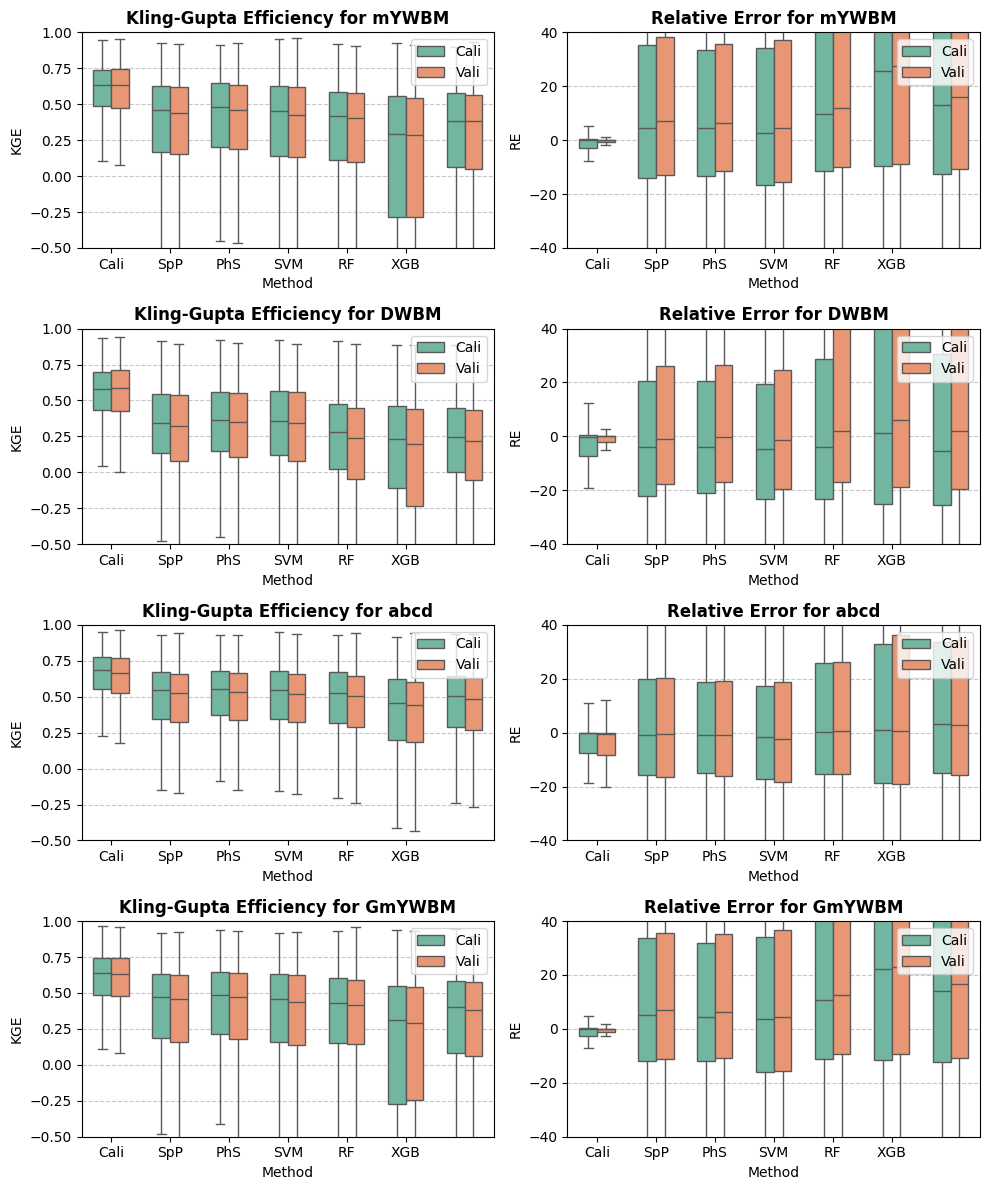

In [6]:
def get_df_plot(basin_list, cali_df, vali_df):
    df_plot = pd.DataFrame({
        'Value': np.concatenate([
            cali_df['Calibrated'].values,   vali_df['Calibrated'].values,
            cali_df['SP_AM'].values,        vali_df['SP_AM'].values,
            cali_df['SP_IDW'].values,       vali_df['SP_IDW'].values,
            cali_df['PS'].values,           vali_df['PS'].values,
            cali_df['RF'].values,           vali_df['RF'].values,
            cali_df['SVM'].values,          vali_df['SVM'].values,
            cali_df['XGB'].values,          vali_df['XGB'].values,
        ]), 
        'Period': (['Cali'] * len(basin_list) + ['Vali'] * len(basin_list)) * 7,
        'Method': ['Calibrated'] * len(basin_list) * 2 + ['SP_AM'] * len(basin_list) * 2 + ['SP_IDW'] * len(basin_list) * 2 + 
                    ['PS'] * len(basin_list) * 2 + ['RF'] * len(basin_list) * 2 +
                    ['SVM'] * len(basin_list) * 2 + ['XGB'] * len(basin_list) * 2
    })
    return df_plot

kge_YM_df_plot  = get_df_plot(basin_list, cali_kge_YM_df,  vali_kge_YM_df)
re_YM_df_plot   = get_df_plot(basin_list, cali_re_YM_df,   vali_re_YM_df)
kge_AM_df_plot  = get_df_plot(basin_list, cali_kge_AM_df,  vali_kge_AM_df)
re_AM_df_plot   = get_df_plot(basin_list, cali_re_AM_df,   vali_re_AM_df)
kge_DM_df_plot  = get_df_plot(basin_list, cali_kge_DM_df,  vali_kge_DM_df)
re_DM_df_plot   = get_df_plot(basin_list, cali_re_DM_df,   vali_re_DM_df)
kge_GYM_df_plot = get_df_plot(basin_list, cali_kge_GYM_df, vali_kge_GYM_df)
re_GYM_df_plot  = get_df_plot(basin_list, cali_re_GYM_df,  vali_re_GYM_df)

def draw_boxplot(ax, data, x, y, hue, title, ylabel, ylim):
    sns.boxplot(ax=ax, data=data, x=x, y=y, hue=hue, palette='Set2', dodge=True, width=0.6, showfliers=False)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend(title='', loc='upper right')
    ax.set_xticks(range(6))
    ax.set_xticklabels(['Cali', 'SpP', 'PhS', 'SVM', 'RF', 'XGB'])

fig, ax = plt.subplots(4, 2, figsize=(10, 12))

ax1_1 = ax[0, 0]
ax1_2 = ax[0, 1]
ax2_1 = ax[1, 0]
ax2_2 = ax[1, 1]
ax3_1 = ax[2, 0]
ax3_2 = ax[2, 1]
ax4_1 = ax[3, 0]
ax4_2 = ax[3, 1]

draw_boxplot(ax1_1, kge_YM_df_plot, 'Method', 'Value', 'Period', 'Kling-Gupta Efficiency for mYWBM', 'KGE', (-0.5, 1.0))
draw_boxplot(ax1_2, re_YM_df_plot, 'Method', 'Value', 'Period', 'Relative Error for mYWBM', 'RE', (-40, 40))
draw_boxplot(ax2_1, kge_DM_df_plot, 'Method', 'Value', 'Period', 'Kling-Gupta Efficiency for DWBM', 'KGE', (-0.5, 1.0))
draw_boxplot(ax2_2, re_DM_df_plot, 'Method', 'Value', 'Period', 'Relative Error for DWBM', 'RE', (-40, 40))
draw_boxplot(ax3_1, kge_AM_df_plot, 'Method', 'Value', 'Period', 'Kling-Gupta Efficiency for abcd', 'KGE', (-0.5, 1.0))
draw_boxplot(ax3_2, re_AM_df_plot, 'Method', 'Value', 'Period', 'Relative Error for abcd', 'RE', (-40, 40))
draw_boxplot(ax4_1, kge_GYM_df_plot, 'Method', 'Value', 'Period', 'Kling-Gupta Efficiency for GmYWBM', 'KGE', (-0.5, 1.0))
draw_boxplot(ax4_2, re_GYM_df_plot, 'Method', 'Value', 'Period', 'Relative Error for GmYWBM', 'RE', (-40, 40))

plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Boxplot_Compare_Rsim_KGE_RE_Cali_Vali_Params_Transplant.eps")
# plt.close()

In [ ]:
def get_df_plot(basin_list, esim_YM_df, esim_AM_df, esim_DM_df, esim_GYM_df):
    df_plot = pd.DataFrame({
        'Value': np.concatenate([
            esim_YM_df['Calibrated'].values,    esim_AM_df['Calibrated'].values,    esim_DM_df['Calibrated'].values,    esim_GYM_df['Calibrated'].values,
            esim_YM_df['SP_AM'].values,         esim_AM_df['SP_AM'].values,         esim_DM_df['SP_AM'].values,         esim_GYM_df['SP_AM'].values,
            esim_YM_df['SP_IDW'].values,        esim_AM_df['SP_IDW'].values,        esim_DM_df['SP_IDW'].values,        esim_GYM_df['SP_IDW'].values,
            esim_YM_df['PS'].values,            esim_AM_df['PS'].values,            esim_DM_df['PS'].values,            esim_GYM_df['PS'].values,
            esim_YM_df['RF'].values,            esim_AM_df['RF'].values,            esim_DM_df['RF'].values,            esim_GYM_df['RF'].values,
            esim_YM_df['SVM'].values,           esim_AM_df['SVM'].values,           esim_DM_df['SVM'].values,           esim_GYM_df['SVM'].values,
            esim_YM_df['XGB'].values,           esim_AM_df['XGB'].values,           esim_DM_df['XGB'].values,           esim_GYM_df['XGB'].values,
        ]), 
        'Period': (['YM'] * len(basin_list) + ['AM'] * len(basin_list) + ['DM'] * len(basin_list) + ['GYM'] * len(basin_list)) * 7,
        'Method': ['Calibrated'] * len(basin_list) * 4 + ['SP_AM'] * len(basin_list) * 4 + ['SP_IDW'] * len(basin_list) * 4 +
                    ['PS'] * len(basin_list) * 4 + ['RF'] * len(basin_list) * 4 +
                    ['SVM'] * len(basin_list) * 4 + ['XGB'] * len(basin_list) * 4
    })
    return df_plot

kge_df_plot = get_df_plot(basin_list, esim_kge_YM_df, esim_kge_AM_df, esim_kge_DM_df, esim_kge_GYM_df)
re_df_plot  = get_df_plot(basin_list, esim_re_YM_df, esim_re_AM_df, esim_re_DM_df, esim_re_GYM_df)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax1 = ax[0]
ax2 = ax[1]

draw_boxplot(ax1, kge_df_plot, 'Method', 'Value', 'Period', 'Kling-Gupta Efficiency for Future Simulation', 'KGE', (-0.2, 1.0))
draw_boxplot(ax2, re_df_plot, 'Method', 'Value', 'Period', 'Relative Error for Future Simulation', 'RE', (-40, 40))

plt.tight_layout()
# plt.savefig("../../Images/Compare_Params_Transplant/Boxplot_Compare_Rsim_KGE_RE_Future_Simulation_Params_Transplant.eps")
# plt.close()

#### 绘制KGE、RE空间分布图

In [6]:
basin_lat_list = basin_info['lat'].values
basin_lon_list = basin_info['lon'].values

In [13]:
from matplotlib import cm, colors
import warnings
warnings.filterwarnings("ignore")

conb_fp   = "../../../2025_03_Hydrological_Models/Data/Shape/Mainland_RB.shp"
conb      = gpd.read_file(conb_fp)

import cartopy.crs as ccrs
projection = ccrs.Robinson()  # 使用自然地球投影方式
extent = [-140, 170, -60, 80]  # 设置经纬度范围
vmin_kge = -0.5
vmax_kge = 1
vmin_re  = -40
vmax_re  = 40
vmin_dkge = -1
vmax_dkge = 0

def plot_conb(ax):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
    conb.plot(ax=ax, color="#ededed", linewidth=1, edgecolor="#bbb", alpha=0.7)

# create new colormap GrRd_CW from the upper half of coolwarm (center -> red)
base_cmap = cm.get_cmap('coolwarm')
GrRd_CW_colors = base_cmap(np.linspace(0.5, 1.0, 128))
GrRd_CW_colors = GrRd_CW_colors[::-1]  # reverse the colors
GrRd_CW = colors.ListedColormap(GrRd_CW_colors, name='GrRd_CW')

fig, ax = plt.subplots(3, 3, figsize=(18, 10), subplot_kw={'projection': projection})

plot_conb(ax[0, 0])
ax[0, 0].scatter(basin_lon_list, basin_lat_list, c=cali_kge_DM_df['Calibrated'], cmap='Blues', vmin=vmin_kge, vmax=vmax_kge, s=6, linewidths=0, transform=ccrs.PlateCarree())
sm = cm.ScalarMappable(cmap='Blues', norm=colors.Normalize(vmin=vmin_kge, vmax=vmax_kge))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0, 0], orientation='horizontal', pad=0.04, fraction=0.05)
cbar.set_label('KGE')
plot_conb(ax[0, 1])
ax[0, 1].scatter(basin_lon_list, basin_lat_list, c=cali_kge_DM_df['SP_AM'] - cali_kge_DM_df['Calibrated'], cmap=GrRd_CW, vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[0, 2])
ax[0, 2].scatter(basin_lon_list, basin_lat_list, c=cali_kge_DM_df['SP_IDW'] - cali_kge_DM_df['Calibrated'], cmap=GrRd_CW, vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 0])
ax[1, 0].scatter(basin_lon_list, basin_lat_list, c=cali_kge_DM_df['PS'] - cali_kge_DM_df['Calibrated'], cmap=GrRd_CW, vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 1])
ax[1, 1].scatter(basin_lon_list, basin_lat_list, c=cali_kge_DM_df['RF'] - cali_kge_DM_df['Calibrated'], cmap=GrRd_CW, vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 2])
ax[1, 2].scatter(basin_lon_list, basin_lat_list, c=cali_kge_DM_df['SVM'] - cali_kge_DM_df['Calibrated'], cmap=GrRd_CW, vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[2, 0])
ax[2, 0].scatter(basin_lon_list, basin_lat_list, c=cali_kge_DM_df['XGB'] - cali_kge_DM_df['Calibrated'], cmap=GrRd_CW, vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
sm = cm.ScalarMappable(cmap=GrRd_CW, norm=colors.Normalize(vmin=vmin_dkge, vmax=vmax_dkge))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[2, 0], orientation='horizontal', pad=0.04, fraction=0.05)
cbar.set_label('DKGE')

plt.savefig("../../Images/Compare_Params_Transplant/Map_Rsim_dKGE_Params_Transplant.eps")
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [14]:
from matplotlib import cm, colors
import warnings
warnings.filterwarnings("ignore")

conb_fp   = "../../../2025_03_Hydrological_Models/Data/Shape/Mainland_RB.shp"
conb      = gpd.read_file(conb_fp)

import cartopy.crs as ccrs
projection = ccrs.Robinson()  # 使用自然地球投影方式
extent = [-140, 170, -60, 80]  # 设置经纬度范围
vmin_kge = 0
vmax_kge = 1
vmin_re  = -40
vmax_re  = 40
vmin_dkge = -0.4
vmax_dkge = 0.4

def plot_conb(ax):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
    conb.plot(ax=ax, color="#ededed", linewidth=1, edgecolor="#bbb", alpha=0.7)

# create new colormap GrRd_CW from the upper half of coolwarm (center -> red)
base_cmap = cm.get_cmap('coolwarm')
GrRd_CW_colors = base_cmap(np.linspace(0.5, 1.0, 128))
GrRd_CW_colors = GrRd_CW_colors[::-1]  # reverse the colors
GrRd_CW = colors.ListedColormap(GrRd_CW_colors, name='GrRd_CW')

fig, ax = plt.subplots(3, 3, figsize=(18, 10), subplot_kw={'projection': projection})

plot_conb(ax[0, 0])
ax[0, 0].scatter(basin_lon_list, basin_lat_list, c=esim_kge_DM_df['Calibrated'], cmap='Greens', vmin=vmin_kge, vmax=vmax_kge, s=6, linewidths=0, transform=ccrs.PlateCarree())
sm = cm.ScalarMappable(cmap='Greens', norm=colors.Normalize(vmin=vmin_kge, vmax=vmax_kge))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0, 0], orientation='horizontal', pad=0.04, fraction=0.05)
cbar.set_label('KGE')
plot_conb(ax[0, 1])
ax[0, 1].scatter(basin_lon_list, basin_lat_list, c=esim_kge_DM_df['SP_AM'] - esim_kge_DM_df['Calibrated'], cmap='RdYlGn', vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[0, 2])
ax[0, 2].scatter(basin_lon_list, basin_lat_list, c=esim_kge_DM_df['SP_IDW'] - esim_kge_DM_df['Calibrated'], cmap='RdYlGn', vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 0])
ax[1, 0].scatter(basin_lon_list, basin_lat_list, c=esim_kge_DM_df['PS'] - esim_kge_DM_df['Calibrated'], cmap='RdYlGn', vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 1])
ax[1, 1].scatter(basin_lon_list, basin_lat_list, c=esim_kge_DM_df['RF'] - esim_kge_DM_df['Calibrated'], cmap='RdYlGn', vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 2])
ax[1, 2].scatter(basin_lon_list, basin_lat_list, c=esim_kge_DM_df['SVM'] - esim_kge_DM_df['Calibrated'], cmap='RdYlGn', vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
plot_conb(ax[2, 0])
ax[2, 0].scatter(basin_lon_list, basin_lat_list, c=esim_kge_DM_df['XGB'] - esim_kge_DM_df['Calibrated'], cmap='RdYlGn', vmin=vmin_dkge, vmax=vmax_dkge, s=6, linewidths=0, transform=ccrs.PlateCarree())
sm = cm.ScalarMappable(cmap='RdYlGn', norm=colors.Normalize(vmin=vmin_dkge, vmax=vmax_dkge))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[2, 0], orientation='horizontal', pad=0.04, fraction=0.05)
cbar.set_label('DKGE')

plt.savefig("../../Images/Compare_Params_Transplant/Map_Esim_dKGE_Params_Transplant.eps")
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## 2. 模型的移植（直接平均、自动选择最佳模型、加权平均）

## 2.1 在流域尺度评估多模型集合效果

### 2.1.1 径流模拟和蒸发模拟的箱线图

#### 运行模型并保存结果

In [ ]:
Rsim_KGE_result_df = pd.DataFrame(np.full((len(basin_list), 11), np.nan), index=basin_list, columns=['YM', 'AM', 'DM', 'GYM', 'BM', 'ArM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC'])
Rsim_RE_result_df  = pd.DataFrame(np.full((len(basin_list), 11), np.nan), index=basin_list, columns=['YM', 'AM', 'DM', 'GYM', 'BM', 'ArM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC'])
Esim_KGE_result_df = pd.DataFrame(np.full((len(basin_list), 11), np.nan), index=basin_list, columns=['YM', 'AM', 'DM', 'GYM', 'BM', 'ArM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC'])
Esim_RE_result_df  = pd.DataFrame(np.full((len(basin_list), 11), np.nan), index=basin_list, columns=['YM', 'AM', 'DM', 'GYM', 'BM', 'ArM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC'])

all_R_weight_AIAC = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_AIAC.txt", sep='\t', index_col=0, header=0)[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
all_R_weight_BMA  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_BMA.txt", sep='\t', index_col=0, header=0)[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
all_R_weight_GRA  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRA.txt", sep='\t', index_col=0, header=0)[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
all_R_weight_GRB  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRB.txt", sep='\t', index_col=0, header=0)[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
all_R_weight_GRC  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRC.txt", sep='\t', index_col=0, header=0)[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]

for basin_idx in trange(len(basin_list)):
    basin = str(basin_list[basin_idx])
    x_cali, y_cali, _, _, _, _ = get_data_lumped(basin, basin_idx)

    rsim_YM, _ = mYWBMnlS_RE(x_cali, params_YM_cali.iloc[basin_idx].values + 1e-6)
    rsim_AM, _ = abcdnlS_RE(x_cali, params_AM_cali.iloc[basin_idx].values + 1e-6)
    rsim_DM, _ = DWBMnlS_RE(x_cali, params_DM_cali.iloc[basin_idx].values + 1e-6)

    x_cali, y_cali, _, _, _, _ = get_data_distributed(basin, basin_idx)
    rsim_GYM, _ = GmYWBM_RE(x_cali, params_GYM_cali.iloc[basin_idx].values + 1e-6)

    rsim_array = np.array([rsim_YM, rsim_AM, rsim_DM, rsim_GYM]).T

    kge_YM  = kling_gupta_efficiency(y_cali, rsim_YM)
    kge_AM  = kling_gupta_efficiency(y_cali, rsim_AM)
    kge_DM  = kling_gupta_efficiency(y_cali, rsim_DM)
    kge_GYM = kling_gupta_efficiency(y_cali, rsim_GYM)
    re_YM   = relative_error(y_cali, rsim_YM)
    re_AM   = relative_error(y_cali, rsim_AM)
    re_DM   = relative_error(y_cali, rsim_DM)
    re_GYM  = relative_error(y_cali, rsim_GYM)

    # choose best model by highest KGE and set rsim_BM (and esim_BM) accordingly, then save metrics
    kges = np.array([kge_YM, kge_AM, kge_DM, kge_GYM], dtype=float)
    best_idx = int(np.nanargmax(kges))
    if best_idx == 0:
        Rsim_BM = rsim_YM
    elif best_idx == 1:
        Rsim_BM = rsim_AM
    elif best_idx == 2:
        Rsim_BM = rsim_DM
    else:
        Rsim_BM = rsim_GYM

    weight_ArM  = np.array([0.25, 0.25, 0.25, 0.25])
    weight_BMA  = all_R_weight_BMA.iloc[basin_idx].values
    weight_AIAC = all_R_weight_AIAC.iloc[basin_idx].values
    weight_GRA  = all_R_weight_GRA.iloc[basin_idx].values
    weight_GRB  = all_R_weight_GRB.iloc[basin_idx].values
    weight_GRC  = all_R_weight_GRC.iloc[basin_idx].values
    Rsim_ArM  = np.dot(rsim_array, weight_ArM)
    Rsim_BMA  = np.dot(rsim_array, weight_BMA)
    Rsim_AIAC = np.dot(rsim_array, weight_AIAC)
    Rsim_GRA  = np.dot(rsim_array, weight_GRA)
    Rsim_GRB  = np.dot(rsim_array, weight_GRB)
    Rsim_GRC  = np.dot(rsim_array, weight_GRC)

    Rsim_KGE_result_df.iloc[basin_idx] = [
        kge_YM, kge_AM, kge_DM, kge_GYM,
        kling_gupta_efficiency(y_cali, Rsim_BM),   kling_gupta_efficiency(y_cali, Rsim_ArM),  kling_gupta_efficiency(y_cali, Rsim_AIAC),   kling_gupta_efficiency(y_cali, Rsim_BMA),
        kling_gupta_efficiency(y_cali, Rsim_GRA),  kling_gupta_efficiency(y_cali, Rsim_GRB),  kling_gupta_efficiency(y_cali, Rsim_GRC),
    ]
    Rsim_RE_result_df.iloc[basin_idx] = [
        re_YM, re_AM, re_DM, re_GYM,
        relative_error(y_cali, Rsim_BM),   relative_error(y_cali, Rsim_ArM),  relative_error(y_cali, Rsim_AIAC),   relative_error(y_cali, Rsim_BMA),
        relative_error(y_cali, Rsim_GRA),  relative_error(y_cali, Rsim_GRB),  relative_error(y_cali, Rsim_GRC),
    ]

Rsim_KGE_result_df.to_csv("../../Results/Weighted_Average/Rsim_KGE_Results_MME.txt", sep='\t', float_format='%.3f')
Rsim_RE_result_df.to_csv("../../Results/Weighted_Average/Rsim_RE_Results_MME.txt", sep='\t', float_format='%.3f')

all_E_weight_AIAC = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_AIAC.txt", sep='\t', index_col=0, header=0)[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
all_E_weight_BMA  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_BMA.txt", sep='\t', index_col=0, header=0)[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
all_E_weight_GRA  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRA.txt", sep='\t', index_col=0, header=0)[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
all_E_weight_GRB  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRB.txt", sep='\t', index_col=0, header=0)[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
all_E_weight_GRC  = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRC.txt", sep='\t', index_col=0, header=0)[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]

for basin_idx in trange(len(basin_list)):
    basin = str(basin_list[basin_idx])
    _, _, _, _, x_esim, y_esim = get_data_lumped(basin, basin_idx)

    _, esim_YM  = mYWBMnlS_RE(x_esim, params_YM_cali.iloc[basin_idx].values + 1e-6)
    _, esim_AM  = abcdnlS_RE(x_esim, params_AM_cali.iloc[basin_idx].values + 1e-6)
    _, esim_DM  = DWBMnlS_RE(x_esim, params_DM_cali.iloc[basin_idx].values + 1e-6)

    _, _, _, _, x_esim, y_esim = get_data_distributed(basin, basin_idx)
    _, esim_GYM = GmYWBM_RE(x_esim, params_GYM_cali.iloc[basin_idx].values + 1e-6)

    esim_array = np.array([esim_YM, esim_AM, esim_DM, esim_GYM]).T

    kge_YM  = kling_gupta_efficiency(y_esim, esim_YM)
    kge_AM  = kling_gupta_efficiency(y_esim, esim_AM)
    kge_DM  = kling_gupta_efficiency(y_esim, esim_DM)
    kge_GYM = kling_gupta_efficiency(y_esim, esim_GYM)
    re_YM   = relative_error(y_esim, esim_YM)
    re_AM   = relative_error(y_esim, esim_AM)
    re_DM   = relative_error(y_esim, esim_DM)
    re_GYM  = relative_error(y_esim, esim_GYM)

    kges = np.array([kge_YM, kge_AM, kge_DM, kge_GYM], dtype=float)
    best_idx = int(np.nanargmax(kges))
    if best_idx == 0:
        Esim_BM = esim_YM
    elif best_idx == 1:
        Esim_BM = esim_AM
    elif best_idx == 2:
        Esim_BM = esim_DM
    else:
        Esim_BM = esim_GYM

    weight_ArM  = np.array([0.25, 0.25, 0.25, 0.25])
    weight_BMA  = all_E_weight_BMA.iloc[basin_idx].values
    weight_AIAC = all_E_weight_AIAC.iloc[basin_idx].values
    weight_GRA  = all_E_weight_GRA.iloc[basin_idx].values
    weight_GRB  = all_E_weight_GRB.iloc[basin_idx].values
    weight_GRC  = all_E_weight_GRC.iloc[basin_idx].values
    Esim_ArM  = np.dot(esim_array, weight_ArM)
    Esim_BMA  = np.dot(esim_array, weight_BMA)
    Esim_AIAC = np.dot(esim_array, weight_AIAC)
    Esim_GRA  = np.dot(esim_array, weight_GRA)
    Esim_GRB  = np.dot(esim_array, weight_GRB)
    Esim_GRC  = np.dot(esim_array, weight_GRC)

    Esim_KGE_result_df.iloc[basin_idx] = [
        kge_YM, kge_AM, kge_DM, kge_GYM,
        kling_gupta_efficiency(y_esim, Esim_BM),   kling_gupta_efficiency(y_esim, Esim_ArM),  kling_gupta_efficiency(y_esim, Esim_AIAC),   kling_gupta_efficiency(y_esim, Esim_BMA),
        kling_gupta_efficiency(y_esim, Esim_GRA),  kling_gupta_efficiency(y_esim, Esim_GRB),  kling_gupta_efficiency(y_esim, Esim_GRC),
    ]
    Esim_RE_result_df.iloc[basin_idx] = [
        re_YM, re_AM, re_DM, re_GYM,
        relative_error(y_esim, Esim_BM),   relative_error(y_esim, Esim_ArM),  relative_error(y_esim, Esim_AIAC),   relative_error(y_esim, Esim_BMA),
        relative_error(y_esim, Esim_GRA),  relative_error(y_esim, Esim_GRB),  relative_error(y_esim, Esim_GRC),
    ]

Esim_KGE_result_df.to_csv("../../Results/Weighted_Average/Esim_KGE_Results_MME.txt", sep='\t', float_format='%.3f')
Esim_RE_result_df.to_csv("../../Results/Weighted_Average/Esim_RE_Results_MME.txt", sep='\t', float_format='%.3f')

#### 读取模型运行结果并画图

In [7]:
Rsim_KGE_result_df = pd.read_csv("../../Results/Weighted_Average/Rsim_KGE_Results_MME.txt", sep='\t', index_col=0)
Rsim_RE_result_df  = pd.read_csv("../../Results/Weighted_Average/Rsim_RE_Results_MME.txt", sep='\t', index_col=0)
Esim_KGE_result_df = pd.read_csv("../../Results/Weighted_Average/Esim_KGE_Results_MME.txt", sep='\t', index_col=0)
Esim_RE_result_df  = pd.read_csv("../../Results/Weighted_Average/Esim_RE_Results_MME.txt", sep='\t', index_col=0)

In [15]:
Rsim_KGE_result_df[Rsim_KGE_result_df < -0.5] = np.nan
Rsim_RE_result_df[Rsim_RE_result_df < -0.5] = np.nan
Rsim_RE_result_df[Rsim_RE_result_df > 0.5]  = np.nan
Esim_KGE_result_df[Esim_KGE_result_df < -0.5] = np.nan
Esim_RE_result_df[Esim_RE_result_df < -0.5] = np.nan
Esim_RE_result_df[Esim_RE_result_df > 0.5]  = np.nan

def draw_boxplot(ax, data, title, ylabel, ylim):
    flierprops = dict(marker='+', markerfacecolor='none', markeredgecolor='darkred', markersize=6, markeredgewidth=1)
    sns.boxplot(ax=ax, data=data, palette='Set2', dodge=False, width=0.6, showfliers=True, flierprops=flierprops)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    # ax.legend(title='', loc='upper right')
    ax.set_xticks(range(11))
    ax.set_xticklabels(['YM', 'AM', 'DM', 'GYM', 'BM', 'ArM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC'])

fig, ax = plt.subplots(2, 2, figsize=(18, 10))

ax1 = ax[0, 0]
ax2 = ax[0, 1]
ax3 = ax[1, 0]
ax4 = ax[1, 1]

draw_boxplot(ax1, Rsim_KGE_result_df, 'Kling-Gupta Efficiency for Future Simulation - Rsim', 'KGE', (0, 1.0))
draw_boxplot(ax2, Rsim_RE_result_df * 100, 'Relative Error for Future Simulation - Rsim', 'RE', (-40, 40))
draw_boxplot(ax3, Esim_KGE_result_df, 'Kling-Gupta Efficiency for Future Simulation - Esim', 'KGE', (0, 1.0))
draw_boxplot(ax4, Esim_RE_result_df * 100, 'Relative Error for Future Simulation - Esim', 'RE', (-40, 40))

plt.savefig("../../Images/Multi_Model_Average/Boxplot_MME_REsim_Method_Compare.eps")
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


#### 多模型平均结果与最佳模型结果的散点图

In [38]:
columes = ['AM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC']
Rsim_MME_dKGE_df = Rsim_KGE_result_df[columes] - Rsim_KGE_result_df['BM'].values[:, None]
Esim_MME_dKGE_df = Esim_KGE_result_df[columes] - Esim_KGE_result_df['BM'].values[:, None]
Rsim_MME_dKGE_df[Rsim_MME_dKGE_df >= 0] = 1
Rsim_MME_dKGE_df[Rsim_MME_dKGE_df < 0]  = 0
Esim_MME_dKGE_df[Esim_MME_dKGE_df >= 0] = 1
Esim_MME_dKGE_df[Esim_MME_dKGE_df < 0]  = 0

def plot_compare_scatter(ax, x, y, c, title=''):
    ax.scatter(x, y, c=c, cmap='bwr', vmin=0, vmax=1, s=10, linewidths=0)
    ax.plot([-0.25, 1.05], [-0.25, 1.05], color='gray', linestyle='--')
    ax.set_xlim(-0.25, 1.05)
    ax.set_ylim(-0.25, 1.05)
    ax.set_title(title, fontweight='bold')

fig, ax = plt.subplots(2, 3, figsize=(10.7, 7))

plot_compare_scatter(ax[0, 0], Rsim_KGE_result_df['BM'],   Rsim_KGE_result_df['AM'],   Rsim_MME_dKGE_df['AM'],   title='Rsim: AM vs BM')
plot_compare_scatter(ax[0, 1], Rsim_KGE_result_df['BM'],   Rsim_KGE_result_df['AIAC'], Rsim_MME_dKGE_df['AIAC'], title='Rsim: AIAC vs BM')
plot_compare_scatter(ax[0, 2], Rsim_KGE_result_df['BM'],   Rsim_KGE_result_df['BMA'],  Rsim_MME_dKGE_df['BMA'],  title='Rsim: BMA vs BM')
plot_compare_scatter(ax[1, 0], Rsim_KGE_result_df['BM'],   Rsim_KGE_result_df['GRA'],  Rsim_MME_dKGE_df['GRA'],  title='Rsim: GRA vs BM')
plot_compare_scatter(ax[1, 1], Rsim_KGE_result_df['BM'],   Rsim_KGE_result_df['GRB'],  Rsim_MME_dKGE_df['GRB'],  title='Rsim: GRB vs BM')
plot_compare_scatter(ax[1, 2], Rsim_KGE_result_df['BM'],   Rsim_KGE_result_df['GRC'],  Rsim_MME_dKGE_df['GRC'],  title='Rsim: GRC vs BM')

plt.tight_layout()
plt.savefig("../../Images/Multi_Model_Average/Scatter_Rsim_dKGE_Compare_with_BM.eps")
plt.close()

In [41]:
columes = ['AM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC']
Rsim_MME_dKGE_df = Rsim_KGE_result_df[columes] - Rsim_KGE_result_df['BM'].values[:, None]
Esim_MME_dKGE_df = Esim_KGE_result_df[columes] - Esim_KGE_result_df['BM'].values[:, None]
Rsim_MME_dKGE_df[Rsim_MME_dKGE_df >= 0] = 1
Rsim_MME_dKGE_df[Rsim_MME_dKGE_df < 0]  = 0
Esim_MME_dKGE_df[Esim_MME_dKGE_df >= 0] = 1
Esim_MME_dKGE_df[Esim_MME_dKGE_df < 0]  = 0

def plot_compare_scatter(ax, x, y, c, title=''):
    ax.scatter(x, y, c=c, cmap='bwr', vmin=0, vmax=1, s=10, linewidths=0)
    ax.plot([-0.25, 1.05], [-0.25, 1.05], color='gray', linestyle='--')
    ax.set_xlim(-0.25, 1.05)
    ax.set_ylim(-0.25, 1.05)
    ax.set_title(title, fontweight='bold')

fig, ax = plt.subplots(2, 3, figsize=(10.7, 7))

plot_compare_scatter(ax[0, 0], Esim_KGE_result_df['BM'],   Esim_KGE_result_df['AM'],   Esim_MME_dKGE_df['AM'],   title='Rsim: AM vs BM')
plot_compare_scatter(ax[0, 1], Esim_KGE_result_df['BM'],   Esim_KGE_result_df['AIAC'], Esim_MME_dKGE_df['AIAC'], title='Rsim: AIAC vs BM')
plot_compare_scatter(ax[0, 2], Esim_KGE_result_df['BM'],   Esim_KGE_result_df['BMA'],  Esim_MME_dKGE_df['BMA'],  title='Rsim: BMA vs BM')
plot_compare_scatter(ax[1, 0], Esim_KGE_result_df['BM'],   Esim_KGE_result_df['GRA'],  Esim_MME_dKGE_df['GRA'],  title='Rsim: GRA vs BM')
plot_compare_scatter(ax[1, 1], Esim_KGE_result_df['BM'],   Esim_KGE_result_df['GRB'],  Esim_MME_dKGE_df['GRB'],  title='Rsim: GRB vs BM')
plot_compare_scatter(ax[1, 2], Esim_KGE_result_df['BM'],   Esim_KGE_result_df['GRC'],  Esim_MME_dKGE_df['GRC'],  title='Rsim: GRC vs BM')

plt.tight_layout()
plt.savefig("../../Images/Multi_Model_Average/Scatter_Esim_dKGE_Compare_with_BM.eps")
plt.close()

#### 多模型平均结果与最佳模型结果的空间分布图

In [7]:
basin_lat_list = basin_info['lat'].values
basin_lon_list = basin_info['lon'].values

from matplotlib import cm, colors
import warnings
warnings.filterwarnings("ignore")

conb_fp   = "../../../2025_03_Hydrological_Models/Data/Shape/Mainland_RB.shp"
conb      = gpd.read_file(conb_fp)

import cartopy.crs as ccrs
projection = ccrs.Robinson()  # 使用自然地球投影方式
extent = [-140, 170, -60, 80]  # 设置经纬度范围
vmin_dkge = -0.5
vmax_dkge = 0.5

def plot_conb(ax):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
    conb.plot(ax=ax, color="#ededed", linewidth=1, edgecolor="#bbb", alpha=0.7)

columes = ['AM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC']
Rsim_MME_dKGE_df = Rsim_KGE_result_df[columes] - Rsim_KGE_result_df['BM'].values[:, None]
Esim_MME_dKGE_df = Esim_KGE_result_df[columes] - Esim_KGE_result_df['BM'].values[:, None]

fig, ax = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': projection})
plot_conb(ax[0, 0])
ax[0, 0].scatter(basin_lon_list, basin_lat_list, c=Rsim_MME_dKGE_df['AM'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[0, 1])
ax[0, 1].scatter(basin_lon_list, basin_lat_list, c=Rsim_MME_dKGE_df['AIAC'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[0, 2])
ax[0, 2].scatter(basin_lon_list, basin_lat_list, c=Rsim_MME_dKGE_df['BMA'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 0])
ax[1, 0].scatter(basin_lon_list, basin_lat_list, c=Rsim_MME_dKGE_df['GRA'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 1])
ax[1, 1].scatter(basin_lon_list, basin_lat_list, c=Rsim_MME_dKGE_df['GRB'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 2])
ax[1, 2].scatter(basin_lon_list, basin_lat_list, c=Rsim_MME_dKGE_df['GRC'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())

sm = cm.ScalarMappable(cmap='coolwarm_r', norm=colors.Normalize(vmin=vmin_dkge, vmax=vmax_dkge))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0, 0], orientation='horizontal', pad=0.04, fraction=0.05)
cbar.set_label('DKGE')

plt.savefig("../../Images/Multi_Model_Average/Map_Rsim_dKGE_MME_vs_BM.eps")
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
basin_lat_list = basin_info['lat'].values
basin_lon_list = basin_info['lon'].values

from matplotlib import cm, colors
import warnings
warnings.filterwarnings("ignore")

conb_fp   = "../../../2025_03_Hydrological_Models/Data/Shape/Mainland_RB.shp"
conb      = gpd.read_file(conb_fp)

import cartopy.crs as ccrs
projection = ccrs.Robinson()  # 使用自然地球投影方式
extent = [-140, 170, -60, 80]  # 设置经纬度范围
vmin_dkge = -0.5
vmax_dkge = 0.5

def plot_conb(ax):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
    conb.plot(ax=ax, color="#ededed", linewidth=1, edgecolor="#bbb", alpha=0.7)

columes = ['AM', 'AIAC', 'BMA', 'GRA', 'GRB', 'GRC']
Rsim_MME_dKGE_df = Rsim_KGE_result_df[columes] - Rsim_KGE_result_df['BM'].values[:, None]
Esim_MME_dKGE_df = Esim_KGE_result_df[columes] - Esim_KGE_result_df['BM'].values[:, None]

fig, ax = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': projection})
plot_conb(ax[0, 0])
ax[0, 0].scatter(basin_lon_list, basin_lat_list, c=Esim_MME_dKGE_df['AM'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[0, 1])
ax[0, 1].scatter(basin_lon_list, basin_lat_list, c=Esim_MME_dKGE_df['AIAC'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[0, 2])
ax[0, 2].scatter(basin_lon_list, basin_lat_list, c=Esim_MME_dKGE_df['BMA'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 0])
ax[1, 0].scatter(basin_lon_list, basin_lat_list, c=Esim_MME_dKGE_df['GRA'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 1])
ax[1, 1].scatter(basin_lon_list, basin_lat_list, c=Esim_MME_dKGE_df['GRB'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())
plot_conb(ax[1, 2])
ax[1, 2].scatter(basin_lon_list, basin_lat_list, c=Esim_MME_dKGE_df['GRC'], cmap='coolwarm_r', vmin=vmin_dkge, vmax=vmax_dkge, s=4, linewidth=0, transform=ccrs.PlateCarree())

sm = cm.ScalarMappable(cmap='coolwarm_r', norm=colors.Normalize(vmin=vmin_dkge, vmax=vmax_dkge))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0, 0], orientation='horizontal', pad=0.04, fraction=0.05)
cbar.set_label('DKGE')

plt.savefig("../../Images/Multi_Model_Average/Map_Esim_dKGE_MME_vs_BM.eps")
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## 2.2 自动选择的最佳模型和实际率定的最佳模型的对比 

In [14]:
best_params_trans = pd.read_csv("../../Results/Best_Model_Transplant/Best_Model_Transplant.txt", sep='\t', header=0, index_col='stat_num')
best_params_calib = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_AIAC.txt", sep='\t', header=0, index_col='stat_num')[['r_kge_YM', 'r_kge_AM', 'r_kge_DM', 'r_kge_GYM']]
best_params_calib = best_params_calib.idxmax(axis=1).map({'r_kge_YM': 0, 'r_kge_AM': 1, 'r_kge_DM': 2, 'r_kge_GYM': 3}).values

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.size': 9
})

cm = confusion_matrix(best_params_calib, best_params_trans['RandomForest'].values, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3]).plot(cmap='Blues', colorbar=False, ax=ax[0,0])
print(classification_report(best_params_calib, best_params_trans['RandomForest'].values, labels=[0, 1, 2, 3], zero_division=0))

cm = confusion_matrix(best_params_calib, best_params_trans['SVM'].values, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3]).plot(cmap='Blues', colorbar=False, ax=ax[0,1])
# print(classification_report(best_params_calib, best_params_trans['SVM'].values, labels=[0, 1, 2, 3], zero_division=0))

cm = confusion_matrix(best_params_calib, best_params_trans['XGBoost'].values, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3]).plot(cmap='Blues', colorbar=False, ax=ax[1,0])
# print(classification_report(best_params_calib, best_params_trans['XGBoost'].values, labels=[0, 1, 2, 3], zero_division=0))

cm = confusion_matrix(best_params_calib, best_params_trans['KNN'].values, labels=[0, 1, 2, 3])
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3]).plot(cmap='Blues', colorbar=False, ax=ax[1,1])
# print(classification_report(best_params_calib, best_params_trans['KNN'].values, labels=[0, 1, 2, 3], zero_division=0))

plt.tight_layout()
plt.savefig("../../Images/Model_Weight_Transplant/Confusion_Matrix_Best_Model_Transplant_vs_Calibrated.eps")
plt.close()

# report_dict_RF  = pd.DataFrame(classification_report(best_params_calib, best_params_trans['RandomForest'].values, labels=[0, 1, 2, 3], output_dict=True, zero_division=0)).transpose()
# report_dict_SVM = pd.DataFrame(classification_report(best_params_calib, best_params_trans['SVM'].values, labels=[0, 1, 2, 3], output_dict=True, zero_division=0)).transpose()
# report_dict_XGB = pd.DataFrame(classification_report(best_params_calib, best_params_trans['XGBoost'].values, labels=[0, 1, 2, 3], output_dict=True, zero_division=0)).transpose()
# report_dict_KNN = pd.DataFrame(classification_report(best_params_calib, best_params_trans['KNN'].values, labels=[0, 1, 2, 3], output_dict=True, zero_division=0)).transpose()

# report_dict_RF.to_excel("../../Results/Best_Model_Transplant/Classification_Report_RandomForest.xlsx", float_format="%.3f")
# report_dict_SVM.to_excel("../../Results/Best_Model_Transplant/Classification_Report_SVM.xlsx", float_format="%.3f")
# report_dict_XGB.to_excel("../../Results/Best_Model_Transplant/Classification_Report_XGBoost.xlsx", float_format="%.3f")
# report_dict_KNN.to_excel("../../Results/Best_Model_Transplant/Classification_Report_KNN.xlsx", float_format="%.3f")

## 2.3 移植的模型权重和实际率定的模型权重的对比

In [7]:
from scipy.stats import gaussian_kde

def plot_scater(ax, x_data, y_data, color, min_value, max_value):
    x_arr = np.asarray(x_data)
    y_arr = np.asarray(y_data)
    valid = ~np.isnan(x_arr) & ~np.isnan(y_arr)
    if not np.any(valid):
        return
    x_clean = x_arr[valid]
    y_clean = y_arr[valid]

    try:
        xy = np.vstack([x_clean, y_clean])
        z = gaussian_kde(xy)(xy)
        idx = np.argsort(z)
        x_sorted = x_clean[idx]
        y_sorted = y_clean[idx]
        z_sorted = z[idx]
        ax.scatter(x_sorted, y_sorted, c=z_sorted, s=3, cmap='Blues', edgecolors='none', alpha=0.7)
    except Exception:
        ax.scatter(x_clean, y_clean, s=1, c=color, alpha=0.5)
    ax.plot([min_value, max_value], [min_value, max_value], c='red', linewidth=0.8, linestyle='--')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    # 右上角显示决定系数 R²
    r = np.corrcoef(x_clean, y_clean)[0, 1]
    r2 = float(r**2)
    return r2

In [35]:
fig, ax = plt.subplots(5, 3, figsize=(9, 15))

r2_results = np.full((5, 3), np.nan)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_AIAC.txt", sep='\t', header=0, index_col='stat_num')[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_AIAC_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_AIAC_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_AIAC_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[0, 0] = plot_scater(ax[0, 0], weight_cali['r_w_AM'], pred_weight_rf['r_w_AM'], 'blue', -0.03, 1.03)
r2_results[0, 1] = plot_scater(ax[0, 1], weight_cali['r_w_AM'], pred_weight_svr['r_w_AM'], 'blue', -0.03, 1.03)
r2_results[0, 2] = plot_scater(ax[0, 2], weight_cali['r_w_AM'], pred_weight_xgb['r_w_AM'], 'blue', -0.03, 1.03)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_BMA.txt", sep='\t', header=0, index_col='stat_num')[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_BMA_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_BMA_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_BMA_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[1, 0] = plot_scater(ax[1, 0], weight_cali['r_w_AM'], pred_weight_rf['r_w_AM'], 'blue', -0.03, 1.03)
r2_results[1, 1] = plot_scater(ax[1, 1], weight_cali['r_w_AM'], pred_weight_svr['r_w_AM'], 'blue', -0.03, 1.03)
r2_results[1, 2] = plot_scater(ax[1, 2], weight_cali['r_w_AM'], pred_weight_xgb['r_w_AM'], 'blue', -0.03, 1.03)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRA.txt", sep='\t', header=0, index_col='stat_num')[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRA_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRA_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRA_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[2, 0] = plot_scater(ax[2, 0], weight_cali['r_w_AM'], pred_weight_rf['r_w_AM'], 'blue', -1, 3)
r2_results[2, 1] = plot_scater(ax[2, 1], weight_cali['r_w_AM'], pred_weight_svr['r_w_AM'], 'blue', -1, 3)
r2_results[2, 2] = plot_scater(ax[2, 2], weight_cali['r_w_AM'], pred_weight_xgb['r_w_AM'], 'blue', -1, 3)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRB.txt", sep='\t', header=0, index_col='stat_num')[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRB_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRB_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRB_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[3, 0] = plot_scater(ax[3, 0], weight_cali['r_w_AM'], pred_weight_rf['r_w_AM'], 'blue', -2, 3)
r2_results[3, 1] = plot_scater(ax[3, 1], weight_cali['r_w_AM'], pred_weight_svr['r_w_AM'], 'blue', -2, 3)
r2_results[3, 2] = plot_scater(ax[3, 2], weight_cali['r_w_AM'], pred_weight_xgb['r_w_AM'], 'blue', -2, 3)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRC.txt", sep='\t', header=0, index_col='stat_num')[['r_w_YM', 'r_w_AM', 'r_w_DM', 'r_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRC_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRC_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRC_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[4, 0] = plot_scater(ax[4, 0], weight_cali['r_w_AM'], pred_weight_rf['r_w_AM'], 'blue', -0.03, 1.03)
r2_results[4, 1] = plot_scater(ax[4, 1], weight_cali['r_w_AM'], pred_weight_svr['r_w_AM'], 'blue', -0.03, 1.03)
r2_results[4, 2] = plot_scater(ax[4, 2], weight_cali['r_w_AM'], pred_weight_xgb['r_w_AM'], 'blue', -0.03, 1.03)

plt.tight_layout()
plt.savefig("../../Images/Model_Weight_Transplant/Scatter_Compare_R_weight_Transplant_vs_Calibrated_AM.eps")
plt.close()

r2_results_df = pd.DataFrame(r2_results, columns=['RF', 'SVM', 'XGB'], index=['AIAC', 'BMA', 'GRA', 'GRB', 'GRC'])
r2_results_df.plot(kind='bar', figsize=(6, 4))
plt.ylabel("R\u00b2")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../../Images/Model_Weight_Transplant/Bar_R2_Compare_R_weight_Transplant_vs_Calibrated_AM.eps")
plt.close()

print(np.round(r2_results, 2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.18 0.14 0.17]
 [0.13 0.06 0.13]
 [0.28 0.24 0.19]
 [0.25 0.25 0.16]
 [0.11 0.04 0.11]]


In [34]:
fig, ax = plt.subplots(5, 3, figsize=(9, 15))

r2_results = np.full((5, 3), np.nan)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_AIAC.txt", sep='\t', header=0, index_col='stat_num')[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_AIAC_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_AIAC_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_AIAC_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[0, 0] = plot_scater(ax[0, 0], weight_cali['e_w_AM'], pred_weight_rf['e_w_AM'], 'blue', -0.03, 1.03)
r2_results[0, 1] = plot_scater(ax[0, 1], weight_cali['e_w_AM'], pred_weight_svr['e_w_AM'], 'blue', -0.03, 1.03)
r2_results[0, 2] = plot_scater(ax[0, 2], weight_cali['e_w_AM'], pred_weight_xgb['e_w_AM'], 'blue', -0.03, 1.03)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_BMA.txt", sep='\t', header=0, index_col='stat_num')[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_BMA_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_BMA_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_BMA_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[1, 0] = plot_scater(ax[1, 0], weight_cali['e_w_AM'], pred_weight_rf['e_w_AM'], 'blue', -0.03, 1.03)
r2_results[1, 1] = plot_scater(ax[1, 1], weight_cali['e_w_AM'], pred_weight_svr['e_w_AM'], 'blue', -0.03, 1.03)
r2_results[1, 2] = plot_scater(ax[1, 2], weight_cali['e_w_AM'], pred_weight_xgb['e_w_AM'], 'blue', -0.03, 1.03)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRA.txt", sep='\t', header=0, index_col='stat_num')[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRA_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRA_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRA_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[2, 0] = plot_scater(ax[2, 0], weight_cali['e_w_AM'], pred_weight_rf['e_w_AM'], 'blue', -1, 3)
r2_results[2, 1] = plot_scater(ax[2, 1], weight_cali['e_w_AM'], pred_weight_svr['e_w_AM'], 'blue', -1, 3)
r2_results[2, 2] = plot_scater(ax[2, 2], weight_cali['e_w_AM'], pred_weight_xgb['e_w_AM'], 'blue', -1, 3)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRB.txt", sep='\t', header=0, index_col='stat_num')[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRB_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRB_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRB_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[3, 0] = plot_scater(ax[3, 0], weight_cali['e_w_AM'], pred_weight_rf['e_w_AM'], 'blue', -2, 3)
r2_results[3, 1] = plot_scater(ax[3, 1], weight_cali['e_w_AM'], pred_weight_svr['e_w_AM'], 'blue', -2, 3)
r2_results[3, 2] = plot_scater(ax[3, 2], weight_cali['e_w_AM'], pred_weight_xgb['e_w_AM'], 'blue', -2, 3)

weight_cali = pd.read_csv("../../Results/Weighted_Average/Weighted_Average_Results_GRC.txt", sep='\t', header=0, index_col='stat_num')[['e_w_YM', 'e_w_AM', 'e_w_DM', 'e_w_GYM']]
pred_weight_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRC_rf.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRC_svr.txt", sep='\t', header=0, index_col='stat_num')
pred_weight_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRC_xgb.txt", sep='\t', header=0, index_col='stat_num')

r2_results[4, 0] = plot_scater(ax[4, 0], weight_cali['e_w_AM'], pred_weight_rf['e_w_AM'], 'blue', -0.03, 1.03)
r2_results[4, 1] = plot_scater(ax[4, 1], weight_cali['e_w_AM'], pred_weight_svr['e_w_AM'], 'blue', -0.03, 1.03)
r2_results[4, 2] = plot_scater(ax[4, 2], weight_cali['e_w_AM'], pred_weight_xgb['e_w_AM'], 'blue', -0.03, 1.03)

plt.tight_layout()
plt.savefig("../../Images/Model_Weight_Transplant/Scatter_Compare_E_weight_Transplant_vs_Calibrated_AM.eps")
plt.close()

r2_results_df = pd.DataFrame(r2_results, columns=['RF', 'SVM', 'XGB'], index=['AIAC', 'BMA', 'GRA', 'GRB', 'GRC'])
r2_results_df.plot(kind='bar', figsize=(6, 4))
plt.ylabel("R\u00b2")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../../Images/Model_Weight_Transplant/Bar_R2_Compare_E_weight_Transplant_vs_Calibrated_AM.eps")
plt.close()

print(np.round(r2_results, 2))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.32 0.27 0.32]
 [0.47 0.35 0.44]
 [0.24 0.21 0.14]
 [0.16 0.18 0.06]
 [0.17 0.08 0.15]]


## 2.3 各种移植模型和率定模型的模拟效果对比

In [35]:
R_pred_weight_AIAC_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_AIAC_rf.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_AIAC_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_AIAC_svr.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_AIAC_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_AIAC_xgb.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_AIAC_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_AIAC_rf.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_AIAC_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_AIAC_svr.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_AIAC_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_AIAC_xgb.txt", sep='\t', header=0, index_col='stat_num')

R_pred_weight_BMA_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_BMA_rf.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_BMA_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_BMA_svr.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_BMA_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_BMA_xgb.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_BMA_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_BMA_rf.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_BMA_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_BMA_svr.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_BMA_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_BMA_xgb.txt", sep='\t', header=0, index_col='stat_num')

R_pred_weight_GRA_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRA_rf.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_GRA_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRA_svr.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_GRA_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRA_xgb.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRA_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRA_rf.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRA_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRA_svr.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRA_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRA_xgb.txt", sep='\t', header=0, index_col='stat_num')

R_pred_weight_GRB_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRB_rf.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_GRB_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRB_svr.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_GRB_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRB_xgb.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRB_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRB_rf.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRB_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRB_svr.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRB_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRB_xgb.txt", sep='\t', header=0, index_col='stat_num')

R_pred_weight_GRC_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRC_rf.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_GRC_svr = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRC_svr.txt", sep='\t', header=0, index_col='stat_num')
R_pred_weight_GRC_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/R_pred_weight_GRC_xgb.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRC_rf  = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRC_rf.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRC_svr = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRC_svr.txt", sep='\t', header=0, index_col='stat_num')
E_pred_weight_GRC_xgb = pd.read_csv("../../Results/Model_Weight_Transplant/E_pred_weight_GRC_xgb.txt", sep='\t', header=0, index_col='stat_num')

In [36]:
def map_best_model(x, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_YM, y_sim_cali_GYM):
    if x == 0:
        return y_sim_cali_YM
    elif x == 1:
        return y_sim_cali_AM
    elif x == 2:
        return y_sim_cali_DM
    elif x == 3:
        return y_sim_cali_GYM
# 加权模型预估
def pred_weight_MME(basin,
                    R_pred_weight_rf, R_pred_weight_svr, R_pred_weight_xgb,
                    E_pred_weight_rf, E_pred_weight_svr, E_pred_weight_xgb,
                    y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM,
                    y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM,
                    y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM,
                    cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re,
                    num1, num2, num3):
    r_pred_weight_rf  = R_pred_weight_rf.loc[basin].values
    r_pred_weight_svr = R_pred_weight_svr.loc[basin].values
    r_pred_weight_xgb = R_pred_weight_xgb.loc[basin].values
    e_pred_weight_rf  = E_pred_weight_rf.loc[basin].values
    e_pred_weight_svr = E_pred_weight_svr.loc[basin].values
    e_pred_weight_xgb = E_pred_weight_xgb.loc[basin].values

    y_sim_cali_WeM_RF  = y_sim_cali_YM * r_pred_weight_rf[0]  + y_sim_cali_AM * r_pred_weight_rf[1]  + y_sim_cali_DM * r_pred_weight_rf[2]  + y_sim_cali_GYM * e_pred_weight_rf[3]
    y_sim_cali_WeM_SVM = y_sim_cali_YM * r_pred_weight_svr[0] + y_sim_cali_AM * r_pred_weight_svr[1] + y_sim_cali_DM * r_pred_weight_svr[2] + y_sim_cali_GYM * e_pred_weight_svr[3]
    y_sim_cali_WeM_XGB = y_sim_cali_YM * r_pred_weight_xgb[0] + y_sim_cali_AM * r_pred_weight_xgb[1] + y_sim_cali_DM * r_pred_weight_xgb[2] + y_sim_cali_GYM * e_pred_weight_xgb[3]
    y_sim_vali_WeM_RF  = y_sim_vali_YM * r_pred_weight_rf[0]  + y_sim_vali_AM * r_pred_weight_rf[1]  + y_sim_vali_DM * r_pred_weight_rf[2]  + y_sim_vali_GYM * e_pred_weight_rf[3]
    y_sim_vali_WeM_SVM = y_sim_vali_YM * r_pred_weight_svr[0] + y_sim_vali_AM * r_pred_weight_svr[1] + y_sim_vali_DM * r_pred_weight_svr[2] + y_sim_vali_GYM * e_pred_weight_svr[3]
    y_sim_vali_WeM_XGB = y_sim_vali_YM * r_pred_weight_xgb[0] + y_sim_vali_AM * r_pred_weight_xgb[1] + y_sim_vali_DM * r_pred_weight_xgb[2] + y_sim_vali_GYM * e_pred_weight_xgb[3]
    y_sim_esim_WeM_RF  = y_sim_esim_YM * r_pred_weight_rf[0]  + y_sim_esim_AM * r_pred_weight_rf[1]  + y_sim_esim_DM * r_pred_weight_rf[2]  + y_sim_esim_GYM * e_pred_weight_rf[3]
    y_sim_esim_WeM_SVM = y_sim_esim_YM * r_pred_weight_svr[0] + y_sim_esim_AM * r_pred_weight_svr[1] + y_sim_esim_DM * r_pred_weight_svr[2] + y_sim_esim_GYM * e_pred_weight_svr[3]
    y_sim_esim_WeM_XGB = y_sim_esim_YM * r_pred_weight_xgb[0] + y_sim_esim_AM * r_pred_weight_xgb[1] + y_sim_esim_DM * r_pred_weight_xgb[2] + y_sim_esim_GYM * e_pred_weight_xgb[3]
    cali_kge[b, num1]  = kling_gupta_efficiency(y_cali_l, y_sim_cali_WeM_RF)
    cali_kge[b, num2]  = kling_gupta_efficiency(y_cali_l, y_sim_cali_WeM_SVM)
    cali_kge[b, num3]  = kling_gupta_efficiency(y_cali_l, y_sim_cali_WeM_XGB)
    cali_re[b, num1]   = relative_error(y_cali_l, y_sim_cali_WeM_RF) * 100
    cali_re[b, num2]   = relative_error(y_cali_l, y_sim_cali_WeM_SVM) * 100
    cali_re[b, num3]   = relative_error(y_cali_l, y_sim_cali_WeM_XGB) * 100
    vali_kge[b, num1]  = kling_gupta_efficiency(y_vali_l, y_sim_vali_WeM_RF)
    vali_kge[b, num2]  = kling_gupta_efficiency(y_vali_l, y_sim_vali_WeM_SVM)
    vali_kge[b, num3]  = kling_gupta_efficiency(y_vali_l, y_sim_vali_WeM_XGB)
    vali_re[b, num1]   = relative_error(y_vali_l, y_sim_vali_WeM_RF) * 100
    vali_re[b, num2]   = relative_error(y_vali_l, y_sim_vali_WeM_SVM) * 100
    vali_re[b, num3]   = relative_error(y_vali_l, y_sim_vali_WeM_XGB) * 100
    esim_kge[b, num1]  = kling_gupta_efficiency(y_esim_l, y_sim_esim_WeM_RF)
    esim_kge[b, num2]  = kling_gupta_efficiency(y_esim_l, y_sim_esim_WeM_SVM)
    esim_kge[b, num3]  = kling_gupta_efficiency(y_esim_l, y_sim_esim_WeM_XGB)
    esim_re[b, num1]   = relative_error(y_esim_l, y_sim_esim_WeM_RF) * 100
    esim_re[b, num2]   = relative_error(y_esim_l, y_sim_esim_WeM_SVM) * 100
    esim_re[b, num3]   = relative_error(y_esim_l, y_sim_esim_WeM_XGB) * 100
    return cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re

cali_kge = np.full((len(basin_list), 24), np.nan)
cali_re  = np.full((len(basin_list), 24), np.nan)
vali_kge = np.full((len(basin_list), 24), np.nan)
vali_re  = np.full((len(basin_list), 24), np.nan)
esim_kge = np.full((len(basin_list), 24), np.nan)
esim_re  = np.full((len(basin_list), 24), np.nan)

for b in trange(len(basin_list)):
    basin = str(basin_list[b])
    # print(f"Processing basin {basin} ({b+1}/{len(basin_list)})...")
    # 获取数据
    x_cali_l, y_cali_l, x_vali_l, y_vali_l, x_esim_l, y_esim_l = get_data_lumped(basin, b)
    x_cali_g, y_cali_g, x_vali_g, y_vali_g, x_esim_g, y_esim_g = get_data_distributed(basin, b)

    # 获取参数
    param_AM  = params_AM_PS.loc[basin].values
    param_DM  = params_DM_PS.loc[basin].values
    param_YM  = params_YM_PS.loc[basin].values
    param_GYM = params_GYM_PS.loc[basin].values

    # 参数移植
    y_sim_cali_AM, _  = abcdnlS_RE(x_cali_l, param_AM)
    y_sim_cali_DM, _  = DWBMnlS_RE(x_cali_l, param_DM)
    y_sim_cali_YM, _  = mYWBMnlS_RE(x_cali_l, param_YM)
    y_sim_cali_GYM, _ = GmYWBM_RE(x_cali_g, param_GYM)

    y_sim_vali_AM, _  = abcdnlS_RE(x_vali_l, param_AM)
    y_sim_vali_DM, _  = DWBMnlS_RE(x_vali_l, param_DM)
    y_sim_vali_YM, _  = mYWBMnlS_RE(x_vali_l, param_YM)
    y_sim_vali_GYM, _ = GmYWBM_RE(x_vali_g, param_GYM)

    _, y_sim_esim_AM  = abcdnlS_RE(x_esim_l, param_AM)
    _, y_sim_esim_DM  = DWBMnlS_RE(x_esim_l, param_DM)
    _, y_sim_esim_YM  = mYWBMnlS_RE(x_esim_l, param_YM)
    _, y_sim_esim_GYM = GmYWBM_RE(x_esim_g, param_GYM)

    cali_kge[b, 0] = kling_gupta_efficiency(y_cali_l, y_sim_cali_YM)
    cali_kge[b, 1] = kling_gupta_efficiency(y_cali_l, y_sim_cali_AM)
    cali_kge[b, 2] = kling_gupta_efficiency(y_cali_l, y_sim_cali_DM)
    cali_kge[b, 3] = kling_gupta_efficiency(y_cali_g, y_sim_cali_GYM)
    cali_re[b, 0]  = relative_error(y_cali_l, y_sim_cali_YM) * 100
    cali_re[b, 1]  = relative_error(y_cali_l, y_sim_cali_AM) * 100
    cali_re[b, 2]  = relative_error(y_cali_l, y_sim_cali_DM) * 100
    cali_re[b, 3]  = relative_error(y_cali_g, y_sim_cali_GYM) * 100

    vali_kge[b, 0] = kling_gupta_efficiency(y_vali_l, y_sim_vali_YM)
    vali_kge[b, 1] = kling_gupta_efficiency(y_vali_l, y_sim_vali_AM)
    vali_kge[b, 2] = kling_gupta_efficiency(y_vali_l, y_sim_vali_DM)
    vali_kge[b, 3] = kling_gupta_efficiency(y_vali_g, y_sim_vali_GYM)
    vali_re[b, 0]  = relative_error(y_vali_l, y_sim_vali_YM) * 100
    vali_re[b, 1]  = relative_error(y_vali_l, y_sim_vali_AM) * 100
    vali_re[b, 2]  = relative_error(y_vali_l, y_sim_vali_DM) * 100
    vali_re[b, 3]  = relative_error(y_vali_g, y_sim_vali_GYM) * 100

    esim_kge[b, 0] = kling_gupta_efficiency(y_esim_l, y_sim_esim_YM)
    esim_kge[b, 1] = kling_gupta_efficiency(y_esim_l, y_sim_esim_AM)
    esim_kge[b, 2] = kling_gupta_efficiency(y_esim_l, y_sim_esim_DM)
    esim_kge[b, 3] = kling_gupta_efficiency(y_esim_g, y_sim_esim_GYM)
    esim_re[b, 0]  = relative_error(y_esim_l, y_sim_esim_YM) * 100
    esim_re[b, 1]  = relative_error(y_esim_l, y_sim_esim_AM) * 100
    esim_re[b, 2]  = relative_error(y_esim_l, y_sim_esim_DM) * 100
    esim_re[b, 3]  = relative_error(y_esim_g, y_sim_esim_GYM) * 100

    # 多模型平均
    y_sim_cali_ArM = (y_sim_cali_AM + y_sim_cali_DM + y_sim_cali_YM + y_sim_cali_GYM) / 4
    y_sim_vali_ArM = (y_sim_vali_AM + y_sim_vali_DM + y_sim_vali_YM + y_sim_vali_GYM) / 4
    y_sim_esim_ArM = (y_sim_esim_AM + y_sim_esim_DM + y_sim_esim_YM + y_sim_esim_GYM) / 4
    cali_kge[b, 4] = kling_gupta_efficiency(y_cali_l, y_sim_cali_ArM)
    cali_re[b, 4]  = relative_error(y_cali_l, y_sim_cali_ArM) * 100
    vali_kge[b, 4] = kling_gupta_efficiency(y_vali_l, y_sim_vali_ArM)
    vali_re[b, 4]  = relative_error(y_vali_l, y_sim_vali_ArM) * 100
    esim_kge[b, 4] = kling_gupta_efficiency(y_esim_l, y_sim_esim_ArM)
    esim_re[b, 4]  = relative_error(y_esim_l, y_sim_esim_ArM) * 100

    # 最佳模型预估
    y_sim_cali_BeM_RF  = map_best_model(best_params_trans.loc[basin, 'RandomForest'], y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM)
    y_sim_cali_BeM_SVM = map_best_model(best_params_trans.loc[basin, 'SVM'], y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM)
    y_sim_cali_BeM_XGB = map_best_model(best_params_trans.loc[basin, 'XGBoost'], y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM)
    y_sim_cali_BeM_KNN = map_best_model(best_params_trans.loc[basin, 'KNN'], y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM)

    y_sim_vali_BeM_RF  = map_best_model(best_params_trans.loc[basin, 'RandomForest'], y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM)
    y_sim_vali_BeM_SVM = map_best_model(best_params_trans.loc[basin, 'SVM'], y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM)
    y_sim_vali_BeM_XGB = map_best_model(best_params_trans.loc[basin, 'XGBoost'], y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM)
    y_sim_vali_BeM_KNN = map_best_model(best_params_trans.loc[basin, 'KNN'], y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM)

    y_sim_esim_BeM_RF  = map_best_model(best_params_trans.loc[basin, 'RandomForest'], y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM)
    y_sim_esim_BeM_SVM = map_best_model(best_params_trans.loc[basin, 'SVM'], y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM)
    y_sim_esim_BeM_XGB = map_best_model(best_params_trans.loc[basin, 'XGBoost'], y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM)
    y_sim_esim_BeM_KNN = map_best_model(best_params_trans.loc[basin, 'KNN'], y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM)

    cali_kge[b, 5] = kling_gupta_efficiency(y_cali_l, y_sim_cali_BeM_RF)
    cali_kge[b, 6] = kling_gupta_efficiency(y_cali_l, y_sim_cali_BeM_SVM)
    cali_kge[b, 7] = kling_gupta_efficiency(y_cali_l, y_sim_cali_BeM_XGB)
    cali_kge[b, 8] = kling_gupta_efficiency(y_cali_l, y_sim_cali_BeM_KNN)
    cali_re[b, 5]  = relative_error(y_cali_l, y_sim_cali_BeM_RF) * 100
    cali_re[b, 6]  = relative_error(y_cali_l, y_sim_cali_BeM_SVM) * 100
    cali_re[b, 7]  = relative_error(y_cali_l, y_sim_cali_BeM_XGB) * 100
    cali_re[b, 8]  = relative_error(y_cali_l, y_sim_cali_BeM_KNN) * 100

    vali_kge[b, 5] = kling_gupta_efficiency(y_vali_l, y_sim_vali_BeM_RF)
    vali_kge[b, 6] = kling_gupta_efficiency(y_vali_l, y_sim_vali_BeM_SVM)
    vali_kge[b, 7] = kling_gupta_efficiency(y_vali_l, y_sim_vali_BeM_XGB)
    vali_kge[b, 8] = kling_gupta_efficiency(y_vali_l, y_sim_vali_BeM_KNN)
    vali_re[b, 5]  = relative_error(y_vali_l, y_sim_vali_BeM_RF) * 100
    vali_re[b, 6]  = relative_error(y_vali_l, y_sim_vali_BeM_SVM) * 100
    vali_re[b, 7]  = relative_error(y_vali_l, y_sim_vali_BeM_XGB) * 100
    vali_re[b, 8]  = relative_error(y_vali_l, y_sim_vali_BeM_KNN) * 100

    esim_kge[b, 5] = kling_gupta_efficiency(y_esim_l, y_sim_esim_BeM_RF)
    esim_kge[b, 6] = kling_gupta_efficiency(y_esim_l, y_sim_esim_BeM_SVM)
    esim_kge[b, 7] = kling_gupta_efficiency(y_esim_l, y_sim_esim_BeM_XGB)
    esim_kge[b, 8] = kling_gupta_efficiency(y_esim_l, y_sim_esim_BeM_KNN)
    esim_re[b, 5]  = relative_error(y_esim_l, y_sim_esim_BeM_RF) * 100
    esim_re[b, 6]  = relative_error(y_esim_l, y_sim_esim_BeM_SVM) * 100
    esim_re[b, 7]  = relative_error(y_esim_l, y_sim_esim_BeM_XGB) * 100
    esim_re[b, 8]  = relative_error(y_esim_l, y_sim_esim_BeM_KNN) * 100

    # 加权模型预估
    cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re = pred_weight_MME(basin,
        R_pred_weight_AIAC_rf, R_pred_weight_AIAC_svr, R_pred_weight_AIAC_xgb, E_pred_weight_AIAC_rf, E_pred_weight_AIAC_svr, E_pred_weight_AIAC_xgb,
        y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM, y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM, y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM,
        cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re, 9, 10, 11
    )
    cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re = pred_weight_MME(basin,
        R_pred_weight_BMA_rf, R_pred_weight_BMA_svr, R_pred_weight_BMA_xgb, E_pred_weight_BMA_rf, E_pred_weight_BMA_svr, E_pred_weight_BMA_xgb,
        y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM, y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM, y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM,
        cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re, 12, 13, 14
    )
    cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re = pred_weight_MME(basin,
        R_pred_weight_GRA_rf, R_pred_weight_GRA_svr, R_pred_weight_GRA_xgb, E_pred_weight_GRA_rf, E_pred_weight_GRA_svr, E_pred_weight_GRA_xgb,
        y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM, y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM, y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM,
        cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re, 15, 16, 17
    )
    cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re = pred_weight_MME(basin,
        R_pred_weight_GRB_rf, R_pred_weight_GRB_svr, R_pred_weight_GRB_xgb, E_pred_weight_GRB_rf, E_pred_weight_GRB_svr, E_pred_weight_GRB_xgb,
        y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM, y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM, y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM,
        cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re, 18, 19, 20
    )
    cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re = pred_weight_MME(basin,
        R_pred_weight_GRC_rf, R_pred_weight_GRC_svr, R_pred_weight_GRC_xgb, E_pred_weight_GRC_rf, E_pred_weight_GRC_svr, E_pred_weight_GRC_xgb,
        y_sim_cali_YM, y_sim_cali_AM, y_sim_cali_DM, y_sim_cali_GYM, y_sim_vali_YM, y_sim_vali_AM, y_sim_vali_DM, y_sim_vali_GYM, y_sim_esim_YM, y_sim_esim_AM, y_sim_esim_DM, y_sim_esim_GYM,
        cali_kge, cali_re, vali_kge, vali_re, esim_kge, esim_re, 21, 22, 23
    )

# 读取格点结果
grids_results_cali_kge = pd.read_csv("../../Results/RE_Sim_from_grids_metrics/Cali_KGE_results.txt", sep='\t', header=0, index_col='stat_num')

cali_kge_df = pd.DataFrame(cali_kge, index=basin_list, columns=['mYWBM', 'abcd', 'DWBM', 'GmYWBM', 'ArM', 'BeM_RF', 'BeM_SVM', 'BeM_XGB', 'BeM_KNN', 'WeM_AIAC_RF', 'WeM_AIAC_SVM', 'WeM_AIAC_XGB', 'WeM_BMA_RF', 'WeM_BMA_SVM', 'WeM_BMA_XGB', 'WeM_GRA_RF', 'WeM_GRA_SVM', 'WeM_GRA_XGB', 'WeM_GRB_RF', 'WeM_GRB_SVM', 'WeM_GRB_XGB', 'WeM_GRC_RF', 'WeM_GRC_SVM', 'WeM_GRC_XGB'])
cali_re_df  = pd.DataFrame(cali_re,  index=basin_list, columns=['mYWBM', 'abcd', 'DWBM', 'GmYWBM', 'ArM', 'BeM_RF', 'BeM_SVM', 'BeM_XGB', 'BeM_KNN', 'WeM_AIAC_RF', 'WeM_AIAC_SVM', 'WeM_AIAC_XGB', 'WeM_BMA_RF', 'WeM_BMA_SVM', 'WeM_BMA_XGB', 'WeM_GRA_RF', 'WeM_GRA_SVM', 'WeM_GRA_XGB', 'WeM_GRB_RF', 'WeM_GRB_SVM', 'WeM_GRB_XGB', 'WeM_GRC_RF', 'WeM_GRC_SVM', 'WeM_GRC_XGB'])
vali_kge_df = pd.DataFrame(vali_kge, index=basin_list, columns=['mYWBM', 'abcd', 'DWBM', 'GmYWBM', 'ArM', 'BeM_RF', 'BeM_SVM', 'BeM_XGB', 'BeM_KNN', 'WeM_AIAC_RF', 'WeM_AIAC_SVM', 'WeM_AIAC_XGB', 'WeM_BMA_RF', 'WeM_BMA_SVM', 'WeM_BMA_XGB', 'WeM_GRA_RF', 'WeM_GRA_SVM', 'WeM_GRA_XGB', 'WeM_GRB_RF', 'WeM_GRB_SVM', 'WeM_GRB_XGB', 'WeM_GRC_RF', 'WeM_GRC_SVM', 'WeM_GRC_XGB'])
vali_re_df  = pd.DataFrame(vali_re,  index=basin_list, columns=['mYWBM', 'abcd', 'DWBM', 'GmYWBM', 'ArM', 'BeM_RF', 'BeM_SVM', 'BeM_XGB', 'BeM_KNN', 'WeM_AIAC_RF', 'WeM_AIAC_SVM', 'WeM_AIAC_XGB', 'WeM_BMA_RF', 'WeM_BMA_SVM', 'WeM_BMA_XGB', 'WeM_GRA_RF', 'WeM_GRA_SVM', 'WeM_GRA_XGB', 'WeM_GRB_RF', 'WeM_GRB_SVM', 'WeM_GRB_XGB', 'WeM_GRC_RF', 'WeM_GRC_SVM', 'WeM_GRC_XGB'])
esim_kge_df = pd.DataFrame(esim_kge, index=basin_list, columns=['mYWBM', 'abcd', 'DWBM', 'GmYWBM', 'ArM', 'BeM_RF', 'BeM_SVM', 'BeM_XGB', 'BeM_KNN', 'WeM_AIAC_RF', 'WeM_AIAC_SVM', 'WeM_AIAC_XGB', 'WeM_BMA_RF', 'WeM_BMA_SVM', 'WeM_BMA_XGB', 'WeM_GRA_RF', 'WeM_GRA_SVM', 'WeM_GRA_XGB', 'WeM_GRB_RF', 'WeM_GRB_SVM', 'WeM_GRB_XGB', 'WeM_GRC_RF', 'WeM_GRC_SVM', 'WeM_GRC_XGB'])
esim_re_df  = pd.DataFrame(esim_re,  index=basin_list, columns=['mYWBM', 'abcd', 'DWBM', 'GmYWBM', 'ArM', 'BeM_RF', 'BeM_SVM', 'BeM_XGB', 'BeM_KNN', 'WeM_AIAC_RF', 'WeM_AIAC_SVM', 'WeM_AIAC_XGB', 'WeM_BMA_RF', 'WeM_BMA_SVM', 'WeM_BMA_XGB', 'WeM_GRA_RF', 'WeM_GRA_SVM', 'WeM_GRA_XGB', 'WeM_GRB_RF', 'WeM_GRB_SVM', 'WeM_GRB_XGB', 'WeM_GRC_RF', 'WeM_GRC_SVM', 'WeM_GRC_XGB'])

  0%|          | 0/2003 [00:00<?, ?it/s]

In [ ]:
grids_results_cali_kge = pd.read_csv("../../Results/RE_Sim_from_grids_metrics/Cali_KGE_results.txt", sep='\t', header=0, index_col='stat_num')['Rsim_GRUN']
grids_results_cali_re  = pd.read_csv("../../Results/RE_Sim_from_grids_metrics/Cali_RE_results.txt", sep='\t', header=0, index_col='stat_num')['Rsim_GRUN']
grids_results_vali_kge = pd.read_csv("../../Results/RE_Sim_from_grids_metrics/Vali_KGE_results.txt", sep='\t', header=0, index_col='stat_num')['Rsim_GRUN']
grids_results_vali_re  = pd.read_csv("../../Results/RE_Sim_from_grids_metrics/Vali_RE_results.txt", sep='\t', header=0, index_col='stat_num')['Rsim_GRUN']
cali_kge_df['GRUN'] = grids_results_cali_kge
cali_re_df['GRUN']  = grids_results_cali_re
vali_kge_df['GRUN'] = grids_results_vali_kge
vali_re_df['GRUN']  = grids_results_vali_re

#### 保存结果

In [39]:
cali_kge_df.to_csv("../../Results/Model_Weight_Transplant/Transplant_Cali_KGE.txt", sep='\t', header=True, index=True, float_format='%.3f')
cali_re_df.to_csv("../../Results/Model_Weight_Transplant/Transplant_Cali_RE.txt", sep='\t', header=True, index=True, float_format='%.3f')
vali_kge_df.to_csv("../../Results/Model_Weight_Transplant/Transplant_Vali_KGE.txt", sep='\t', header=True, index=True, float_format='%.3f')
vali_re_df.to_csv("../../Results/Model_Weight_Transplant/Transplant_Vali_RE.txt", sep='\t', header=True, index=True, float_format='%.3f')
esim_kge_df.to_csv("../../Results/Model_Weight_Transplant/Transplant_Esim_KGE.txt", sep='\t', header=True, index=True, float_format='%.3f')
esim_re_df.to_csv("../../Results/Model_Weight_Transplant/Transplant_Esim_RE.txt", sep='\t', header=True, index=True, float_format='%.3f')

#### 加载结果

In [40]:
cali_kge_df = pd.read_csv("../../Results/Model_Weight_Transplant/Transplant_Cali_KGE.txt", sep='\t', header=0, index_col='stat_num')
cali_re_df  = pd.read_csv("../../Results/Model_Weight_Transplant/Transplant_Cali_RE.txt", sep='\t', header=0, index_col='stat_num')
vali_kge_df = pd.read_csv("../../Results/Model_Weight_Transplant/Transplant_Vali_KGE.txt", sep='\t', header=0, index_col='stat_num')
vali_re_df  = pd.read_csv("../../Results/Model_Weight_Transplant/Transplant_Vali_RE.txt", sep='\t', header=0, index_col='stat_num')
esim_kge_df = pd.read_csv("../../Results/Model_Weight_Transplant/Transplant_Esim_KGE.txt", sep='\t', header=0, index_col='stat_num')
esim_re_df  = pd.read_csv("../../Results/Model_Weight_Transplant/Transplant_Esim_RE.txt", sep='\t', header=0, index_col='stat_num')

In [41]:
cali_kge_df[cali_kge_df < -0.5] = np.nan
vali_kge_df[vali_kge_df < -0.5] = np.nan
esim_kge_df[esim_kge_df < -0.5] = np.nan

cali_re_df[cali_re_df > 50] = np.nan
vali_re_df[vali_re_df > 50] = np.nan
esim_re_df[esim_re_df > 50] = np.nan

cali_re_df[cali_re_df < -50] = np.nan
vali_re_df[vali_re_df < -50] = np.nan
esim_re_df[esim_re_df < -50] = np.nan

(-40.0, 40.0)

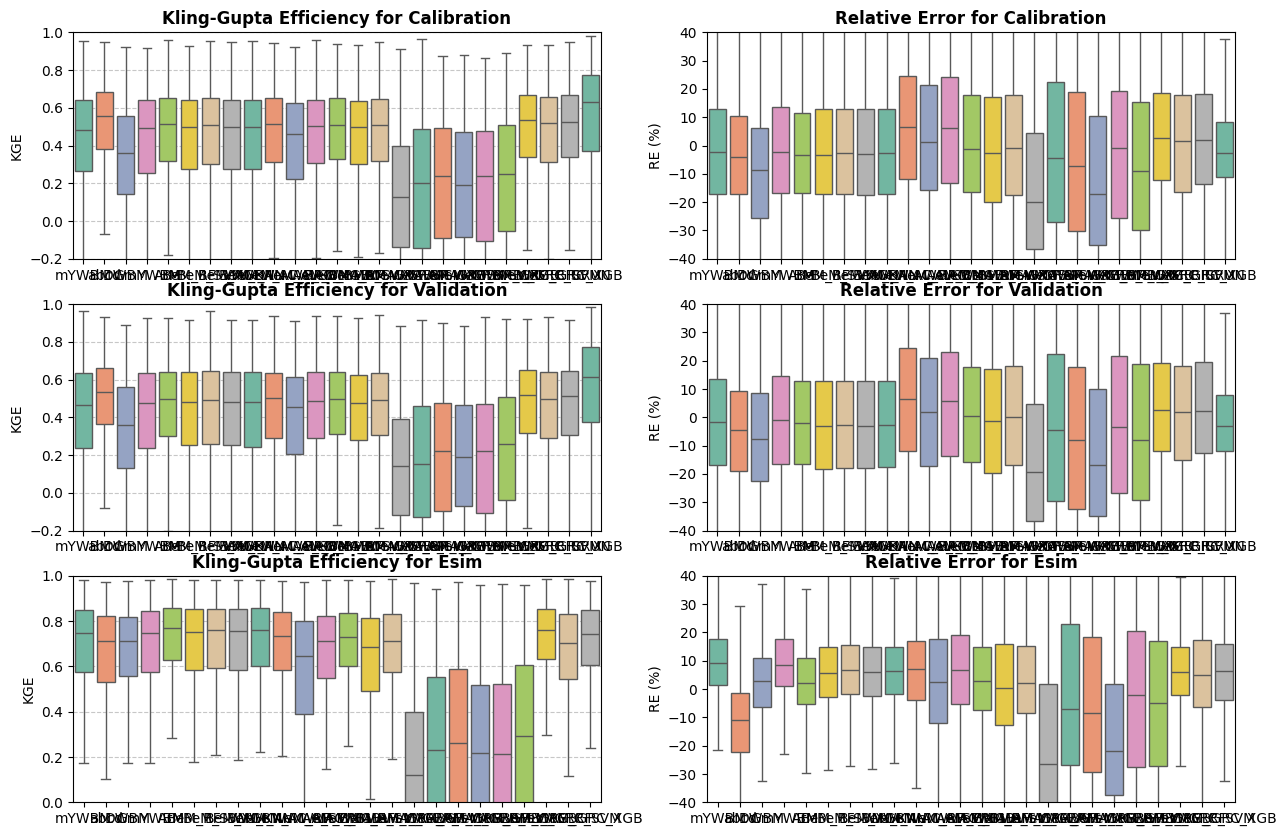

In [42]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

sns.boxplot(ax=ax[0, 0], data=cali_kge_df, palette='Set2', showfliers=False)
ax[0, 0].set_title('Kling-Gupta Efficiency for Calibration', fontweight='bold')
ax[0, 0].set_ylabel('KGE')
ax[0, 0].set_ylim(-0.2, 1.0)
ax[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

sns.boxplot(ax=ax[0, 1], data=cali_re_df, palette='Set2', showfliers=False)
ax[0, 1].set_title('Relative Error for Calibration', fontweight='bold')
ax[0, 1].set_ylabel('RE (%)')
ax[0, 1].set_ylim(-40, 40)

sns.boxplot(ax=ax[1, 0], data=vali_kge_df, palette='Set2', showfliers=False)
ax[1, 0].set_title('Kling-Gupta Efficiency for Validation', fontweight='bold')
ax[1, 0].set_ylabel('KGE')
ax[1, 0].set_ylim(-0.2, 1.0)
ax[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

sns.boxplot(ax=ax[1, 1], data=vali_re_df, palette='Set2', showfliers=False)
ax[1, 1].set_title('Relative Error for Validation', fontweight='bold')
ax[1, 1].set_ylabel('RE (%)')
ax[1, 1].set_ylim(-40, 40)

sns.boxplot(ax=ax[2, 0], data=esim_kge_df, palette='Set2', showfliers=False)
ax[2, 0].set_title('Kling-Gupta Efficiency for Esim', fontweight='bold')
ax[2, 0].set_ylabel('KGE')
ax[2, 0].set_ylim(0, 1.0)
ax[2, 0].grid(axis='y', linestyle='--', alpha=0.7)

sns.boxplot(ax=ax[2, 1], data=esim_re_df, palette='Set2', showfliers=False)
ax[2, 1].set_title('Relative Error for Esim', fontweight='bold')
ax[2, 1].set_ylabel('RE (%)')
ax[2, 1].set_ylim(-40, 40)

# plt.savefig("../../Images/Model_Weight_Transplant/Model_Weight_Transplant_Performance_Boxplot.eps")
# plt.close()

# 3. 向格点移植

In [3]:
def get_mask(lon_grid, lat_grid, poly):
    pts = [Point(x, y) for x, y in zip(lon_grid.ravel(), lat_grid.ravel())]
    inside = np.array([poly.contains(p) for p in pts], dtype=bool)
    basin_mask = inside.reshape(lat_grid.shape).astype(float)
    basin_mask[~inside.reshape(lat_grid.shape)] = np.nan
    return basin_mask

## 运行模型获取基于格点的流域径流模拟

### 数据读取

In [48]:
shp_path = r"../../../2024_05_Model_Compare/Data/Shape/Study_Area_84.shp"
study_area = gpd.read_file(shp_path)

Rsim_AM_cru        = np.load("../../Results/Grids_Simulation_Results/Rsim_AM_cru.npy").astype(np.float32)
Rsim_YM_cru        = np.load("../../Results/Grids_Simulation_Results/Rsim_YM_cru.npy").astype(np.float32)
Rsim_DM_cru        = np.load("../../Results/Grids_Simulation_Results/Rsim_DM_cru.npy").astype(np.float32)
Rsim_ArM_cru       = np.load("../../Results/Grids_Simulation_Results/Rsim_ArM_cru.npy").astype(np.float32)
Rsim_BM_cru        = np.load("../../Results/Grids_Simulation_Results/Rsim_BM_svr_cru.npy").astype(np.float32)
Rsim_AIAC_rf_cru   = np.load("../../Results/Grids_Simulation_Results/Rsim_AIAC_rf_cru.npy").astype(np.float32)
Rsim_AIAC_xgb_cru  = np.load("../../Results/Grids_Simulation_Results/Rsim_AIAC_xgb_cru.npy").astype(np.float32)
Rsim_BMA_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_BMA_rf_cru.npy").astype(np.float32)
Rsim_BMA_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Rsim_BMA_xgb_cru.npy").astype(np.float32)
Rsim_GRA_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_GRA_rf_cru.npy").astype(np.float32)
Rsim_GRA_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Rsim_GRA_xgb_cru.npy").astype(np.float32)
Rsim_GRB_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_GRB_rf_cru.npy").astype(np.float32)
Rsim_GRB_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Rsim_GRB_xgb_cru.npy").astype(np.float32)
Rsim_GRC_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_GRC_rf_cru.npy").astype(np.float32)
Rsim_GRC_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Rsim_GRC_xgb_cru.npy").astype(np.float32)

Rsim_dbh           = np.load("../../Data/ISIMIP2a_outputs/dbh_qtot_1971_2010.npy").astype(np.float32)
Rsim_h08           = np.load("../../Data/ISIMIP2a_outputs/h08_qtot_1971_2010.npy").astype(np.float32)
Rsim_lpjml         = np.load("../../Data/ISIMIP2a_outputs/lpjml_qtot_1971_2010.npy").astype(np.float32)
Rsim_pcr           = np.load("../../Data/ISIMIP2a_outputs/pcr_globwb_qtot_1971_2010.npy").astype(np.float32)
Rsim_vic           = np.load("../../Data/ISIMIP2a_outputs/vic_qtot_1971_2010.npy").astype(np.float32)

Rsim_GRUN          = np.load("../../Data/GRUN/GRUN_1901_2014.npy").astype(np.float32)

Rsim_AM_cru[0]          = Rsim_AM_cru[1]
Rsim_YM_cru[0]          = Rsim_YM_cru[1]
Rsim_DM_cru[0]          = Rsim_DM_cru[1]
Rsim_ArM_cru[0]         = Rsim_ArM_cru[1]
Rsim_BM_cru[0]          = Rsim_BM_cru[1]
Rsim_AIAC_rf_cru[0]     = Rsim_AIAC_rf_cru[1]
Rsim_AIAC_xgb_cru[0]    = Rsim_AIAC_xgb_cru[1]
Rsim_BMA_rf_cru[0]      = Rsim_BMA_rf_cru[1]
Rsim_BMA_xgb_cru[0]     = Rsim_BMA_xgb_cru[1]
Rsim_GRA_rf_cru[0]      = Rsim_GRA_rf_cru[1]
Rsim_GRA_xgb_cru[0]     = Rsim_GRA_xgb_cru[1]
Rsim_GRB_rf_cru[0]      = Rsim_GRB_rf_cru[1]
Rsim_GRB_xgb_cru[0]     = Rsim_GRB_xgb_cru[1]
Rsim_GRC_rf_cru[0]      = Rsim_GRC_rf_cru[1]
Rsim_GRC_xgb_cru[0]     = Rsim_GRC_xgb_cru[1]

time_series_cru   = pd.date_range(start='1901-01-01', end='2022-12-31', freq='MS')
time_series_ghm   = pd.date_range(start='1971-01-01', end='2010-12-31', freq='MS')
time_series_grun  = pd.date_range(start='1902-01-01', end='2014-12-31', freq='MS')

lon_series = np.load("../../Data/forcing/lon.npy")
lat_series = np.load("../../Data/forcing/lat.npy")

In [49]:
for i in trange(len(study_area)):
    basin = study_area.loc[i]
    basin_name = str(basin['basin_name'])
    poly = basin['geometry']

    # 获取多边形边界 (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy   = poly.bounds
    left, right, bottom, top = minx, maxx, miny, maxy

    # 根据边界在经纬序列上定位索引范围（拓展一点缓冲以确保包含边界格点）
    lon_idx = np.where((lon_series >= left - 2) & (lon_series <= right + 2))[0]
    lat_idx = np.where((lat_series <= top + 2) & (lat_series >= bottom - 2))[0]

    lon_min, lon_max = lon_idx.min(), lon_idx.max()
    lat_min, lat_max = lat_idx.min(), lat_idx.max()

    # 子区域经纬
    lon_sub = lon_series[lon_min:lon_max+1]
    lat_sub = lat_series[lat_min:lat_max+1]

    # 生成子网格并计算掩膜
    lon_grid_sub, lat_grid_sub = np.meshgrid(lon_sub, lat_sub)
    sub_mask = get_mask(lon_grid_sub, lat_grid_sub, poly)
    if np.all(np.isnan(sub_mask)):
        continue
    if np.all(np.isnan(sub_mask * Rsim_AM_cru[0, lat_min:lat_max+1, lon_min:lon_max+1])):
        continue
    sub_mask_3d = sub_mask[np.newaxis, :, :]

    all_hc = pd.read_csv(f"../../../2025_03_Hydrological_Models/Data/New_Hydro_Climatic/NHC_{basin_name}.txt", header=0, parse_dates=['Time'], index_col='Time', sep='\t')

    Rsim_basin_results = pd.DataFrame(index = all_hc.index, columns = ['Robs', 'Rsim_AM_cru', 'Rsim_YM_cru', 'Rsim_DM_cru', 'Rsim_ArM_cru', 'Rsim_BM_cru',
                                                                       'Rsim_AIAC_rf_cru', 'Rsim_AIAC_xgb_cru', 'Rsim_BMA_rf_cru', 'Rsim_BMA_xgb_cru',
                                                                       'Rsim_GRA_rf_cru', 'Rsim_GRA_xgb_cru', 'Rsim_GRB_rf_cru', 'Rsim_GRB_xgb_cru',
                                                                       'Rsim_GRC_rf_cru', 'Rsim_GRC_xgb_cru', 'Rsim_GRUN',
                                                                       'Rsim_dbh', 'Rsim_h08', 'Rsim_lpjml', 'Rsim_pcr', 'Rsim_vic'])
    Rsim_basin_results['Robs'] = all_hc['RUN']
    Rsim_basin_results['Rsim_AM_cru']        = pd.Series(np.nanmean(Rsim_AM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_YM_cru']        = pd.Series(np.nanmean(Rsim_YM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_DM_cru']        = pd.Series(np.nanmean(Rsim_DM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_ArM_cru']       = pd.Series(np.nanmean(Rsim_ArM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_BM_cru']        = pd.Series(np.nanmean(Rsim_BM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_AIAC_rf_cru']   = pd.Series(np.nanmean(Rsim_AIAC_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_AIAC_xgb_cru']  = pd.Series(np.nanmean(Rsim_AIAC_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_BMA_rf_cru']    = pd.Series(np.nanmean(Rsim_BMA_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_BMA_xgb_cru']   = pd.Series(np.nanmean(Rsim_BMA_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_GRA_rf_cru']    = pd.Series(np.nanmean(Rsim_GRA_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_GRA_xgb_cru']   = pd.Series(np.nanmean(Rsim_GRA_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_GRB_rf_cru']    = pd.Series(np.nanmean(Rsim_GRB_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_GRB_xgb_cru']   = pd.Series(np.nanmean(Rsim_GRB_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_GRC_rf_cru']    = pd.Series(np.nanmean(Rsim_GRC_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_GRC_xgb_cru']   = pd.Series(np.nanmean(Rsim_GRC_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Rsim_basin_results['Rsim_GRUN']          = pd.Series(np.nanmean(Rsim_GRUN[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_grun)

    Rsim_basin_results['Rsim_dbh']             = pd.Series(np.nanmean(Rsim_dbh[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Rsim_basin_results['Rsim_h08']             = pd.Series(np.nanmean(Rsim_h08[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Rsim_basin_results['Rsim_lpjml']           = pd.Series(np.nanmean(Rsim_lpjml[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Rsim_basin_results['Rsim_pcr']             = pd.Series(np.nanmean(Rsim_pcr[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Rsim_basin_results['Rsim_vic']             = pd.Series(np.nanmean(Rsim_vic[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    
    Rsim_basin_results.to_csv(f"../../Results/REsim_from_grids/Rsim_{basin_name}.txt", sep='\t', float_format='%.2f')

  0%|          | 0/2003 [00:00<?, ?it/s]

In [50]:
del Rsim_AM_cru, Rsim_YM_cru, Rsim_DM_cru, Rsim_ArM_cru, Rsim_BM_cru
del Rsim_AIAC_rf_cru, Rsim_AIAC_xgb_cru, Rsim_BMA_rf_cru, Rsim_BMA_xgb_cru
del Rsim_GRA_rf_cru, Rsim_GRA_xgb_cru, Rsim_GRB_rf_cru, Rsim_GRB_xgb_cru
del Rsim_GRC_rf_cru, Rsim_GRC_xgb_cru, Rsim_GRUN
del Rsim_dbh, Rsim_h08, Rsim_lpjml, Rsim_pcr, Rsim_vic

In [2]:
shp_path = r"../../../2024_05_Model_Compare/Data/Shape/Study_Area_84.shp"
study_area = gpd.read_file(shp_path)

Esim_AM_cru        = np.load("../../Results/Grids_Simulation_Results/Esim_AM_cru.npy").astype(np.float32)
Esim_YM_cru        = np.load("../../Results/Grids_Simulation_Results/Esim_YM_cru.npy").astype(np.float32)
Esim_DM_cru        = np.load("../../Results/Grids_Simulation_Results/Esim_DM_cru.npy").astype(np.float32)
Esim_ArM_cru       = np.load("../../Results/Grids_Simulation_Results/Esim_ArM_cru.npy").astype(np.float32)
Esim_BM_cru        = np.load("../../Results/Grids_Simulation_Results/Esim_BM_svr_cru.npy").astype(np.float32)
Esim_AIAC_rf_cru   = np.load("../../Results/Grids_Simulation_Results/Esim_AIAC_rf_cru.npy").astype(np.float32)
Esim_AIAC_xgb_cru  = np.load("../../Results/Grids_Simulation_Results/Esim_AIAC_xgb_cru.npy").astype(np.float32)
Esim_BMA_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Esim_BMA_rf_cru.npy").astype(np.float32)
Esim_BMA_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Esim_BMA_xgb_cru.npy").astype(np.float32)
Esim_GRA_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Esim_GRA_rf_cru.npy").astype(np.float32)
Esim_GRA_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Esim_GRA_xgb_cru.npy").astype(np.float32)
Esim_GRB_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Esim_GRB_rf_cru.npy").astype(np.float32)
Esim_GRB_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Esim_GRB_xgb_cru.npy").astype(np.float32)
Esim_GRC_rf_cru    = np.load("../../Results/Grids_Simulation_Results/Esim_GRC_rf_cru.npy").astype(np.float32)
Esim_GRC_xgb_cru   = np.load("../../Results/Grids_Simulation_Results/Esim_GRC_xgb_cru.npy").astype(np.float32)

Esim_dbh           = np.load("../../Data/ISIMIP2a_outputs/dbh_evap_1971_2010.npy").astype(np.float32) * 86400 * 30.4
Esim_h08           = np.load("../../Data/ISIMIP2a_outputs/h08_evap_1971_2010.npy").astype(np.float32) * 86400 * 30.4
Esim_lpjml         = np.load("../../Data/ISIMIP2a_outputs/lpjml_evap_1971_2010.npy").astype(np.float32) * 86400 * 30.4
Esim_pcr           = np.load("../../Data/ISIMIP2a_outputs/pcr_globwb_evap_1971_2010.npy").astype(np.float32) * 86400 * 30.4
Esim_vic           = np.load("../../Data/ISIMIP2a_outputs/vic_evap_1971_2010.npy").astype(np.float32) * 86400 * 30.4

Esim_AM_cru[0]          = Esim_AM_cru[1]
Esim_YM_cru[0]          = Esim_YM_cru[1]
Esim_DM_cru[0]          = Esim_DM_cru[1]
Esim_ArM_cru[0]         = Esim_ArM_cru[1]
Esim_BM_cru[0]          = Esim_BM_cru[1]
Esim_AIAC_rf_cru[0]     = Esim_AIAC_rf_cru[1]
Esim_AIAC_xgb_cru[0]    = Esim_AIAC_xgb_cru[1]
Esim_BMA_rf_cru[0]      = Esim_BMA_rf_cru[1]
Esim_BMA_xgb_cru[0]     = Esim_BMA_xgb_cru[1]
Esim_GRA_rf_cru[0]      = Esim_GRA_rf_cru[1]
Esim_GRA_xgb_cru[0]     = Esim_GRA_xgb_cru[1]
Esim_GRB_rf_cru[0]      = Esim_GRB_rf_cru[1]
Esim_GRB_xgb_cru[0]     = Esim_GRB_xgb_cru[1]
Esim_GRC_rf_cru[0]      = Esim_GRC_rf_cru[1]
Esim_GRC_xgb_cru[0]     = Esim_GRC_xgb_cru[1]

time_series_cru   = pd.date_range(start='1901-01-01', end='2022-12-31', freq='MS')
time_series_ghm   = pd.date_range(start='1971-01-01', end='2010-12-31', freq='MS')
time_series_grun  = pd.date_range(start='1902-01-01', end='2014-12-31', freq='MS')

lon_series = np.load("../../Data/forcing/lon.npy")
lat_series = np.load("../../Data/forcing/lat.npy")

In [6]:
for i in trange(len(study_area)):
    basin = study_area.loc[i]
    basin_name = str(basin['basin_name'])
    poly = basin['geometry']

    # 获取多边形边界 (minx, miny, maxx, maxy)
    minx, miny, maxx, maxy   = poly.bounds
    left, right, bottom, top = minx, maxx, miny, maxy

    # 根据边界在经纬序列上定位索引范围（拓展一点缓冲以确保包含边界格点）
    lon_idx = np.where((lon_series >= left - 2) & (lon_series <= right + 2))[0]
    lat_idx = np.where((lat_series <= top + 2) & (lat_series >= bottom - 2))[0]

    lon_min, lon_max = lon_idx.min(), lon_idx.max()
    lat_min, lat_max = lat_idx.min(), lat_idx.max()

    # 子区域经纬
    lon_sub = lon_series[lon_min:lon_max+1]
    lat_sub = lat_series[lat_min:lat_max+1]

    # 生成子网格并计算掩膜
    lon_grid_sub, lat_grid_sub = np.meshgrid(lon_sub, lat_sub)
    sub_mask = get_mask(lon_grid_sub, lat_grid_sub, poly)
    if np.all(np.isnan(sub_mask)):
        continue
    if np.all(np.isnan(sub_mask * Esim_AM_cru[0, lat_min:lat_max+1, lon_min:lon_max+1])):
        continue
    sub_mask_3d = sub_mask[np.newaxis, :, :]

    all_hc = pd.read_csv(f"../../../2025_03_Hydrological_Models/Data/AE/AE_{basin_name}.txt", header=0, parse_dates=['Time'], index_col='Time', sep='\t')

    Esim_basin_results = pd.DataFrame(index = all_hc.index, columns = ['Eobs', 'Esim_AM_cru', 'Esim_YM_cru', 'Esim_DM_cru', 'Esim_ArM_cru', 'Esim_BM_cru',
                                                                       'Esim_AIAC_rf_cru', 'Esim_AIAC_xgb_cru', 'Esim_BMA_rf_cru', 'Esim_BMA_xgb_cru',
                                                                       'Esim_GRA_rf_cru', 'Esim_GRA_xgb_cru', 'Esim_GRB_rf_cru', 'Esim_GRB_xgb_cru',
                                                                       'Esim_GRC_rf_cru', 'Esim_GRC_xgb_cru',
                                                                       'Esim_dbh', 'Esim_h08', 'Esim_lpjml', 'Esim_pcr', 'Esim_vic'])
    Esim_basin_results['Eobs'] = all_hc['AE']
    Esim_basin_results['Esim_AM_cru']        = pd.Series(np.nanmean(Esim_AM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_YM_cru']        = pd.Series(np.nanmean(Esim_YM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_DM_cru']        = pd.Series(np.nanmean(Esim_DM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_ArM_cru']       = pd.Series(np.nanmean(Esim_ArM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_BM_cru']        = pd.Series(np.nanmean(Esim_BM_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_AIAC_rf_cru']   = pd.Series(np.nanmean(Esim_AIAC_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_AIAC_xgb_cru']  = pd.Series(np.nanmean(Esim_AIAC_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_BMA_rf_cru']    = pd.Series(np.nanmean(Esim_BMA_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_BMA_xgb_cru']   = pd.Series(np.nanmean(Esim_BMA_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_GRA_rf_cru']    = pd.Series(np.nanmean(Esim_GRA_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_GRA_xgb_cru']   = pd.Series(np.nanmean(Esim_GRA_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_GRB_rf_cru']    = pd.Series(np.nanmean(Esim_GRB_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_GRB_xgb_cru']   = pd.Series(np.nanmean(Esim_GRB_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_GRC_rf_cru']    = pd.Series(np.nanmean(Esim_GRC_rf_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)
    Esim_basin_results['Esim_GRC_xgb_cru']   = pd.Series(np.nanmean(Esim_GRC_xgb_cru[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_cru)

    Esim_basin_results['Esim_dbh']             = pd.Series(np.nanmean(Esim_dbh[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Esim_basin_results['Esim_h08']             = pd.Series(np.nanmean(Esim_h08[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Esim_basin_results['Esim_lpjml']           = pd.Series(np.nanmean(Esim_lpjml[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Esim_basin_results['Esim_pcr']             = pd.Series(np.nanmean(Esim_pcr[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    Esim_basin_results['Esim_vic']             = pd.Series(np.nanmean(Esim_vic[:, lat_min:lat_max+1, lon_min:lon_max+1] * sub_mask_3d, axis = (1, 2)), index = time_series_ghm)
    
    Esim_basin_results.to_csv(f"../../Results/REsim_from_grids/Esim_{basin_name}.txt", sep='\t', float_format='%.2f')

  0%|          | 0/2003 [00:00<?, ?it/s]

## 绘图

In [4]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_stretch_map(ax, data, title, vmin, vmax, cmap='Blues', extend=None):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    img = ax.imshow(data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    # ax.coastlines()
    ax.set_title(title, fontsize=12)
    ax.gridlines(xlocs=range(-180, 181, 60), ylocs=range(-60, 91, 30), linestyle='-.', color='#474747', linewidth=1)
    cbar = plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.05, fraction=0.05, extend=extend)
    cbar.ax.tick_params(labelsize=10)
def plot_classification_map(ax, data, title):
    cmap = ListedColormap(['lightblue', 'orange', 'red'])
    bounds = [0, 1, 2, 3]
    norm = BoundaryNorm(bounds, cmap.N)
    im = ax.imshow(data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5], orientation='vertical', pad=0.05)
    cbar.ax.set_yticklabels(['Class 0', 'Class 1', 'Class 2'])
    return im

### 模型参数空间分布图

In [ ]:
method = "PS"
ds = xr.open_dataset(f"../../Results/Grids_Params_Transplant/AM_{method}.nc")
a_AM   = ds['ks']
b_AM   = ds['kg']
c_AM   = ds['alpha']
d_AM   = ds['smax']
ksn_AM = ds['ksn']
ds.close()
ds = xr.open_dataset(f"../../Results/Grids_Params_Transplant/YM_{method}.nc")
m_YM     = ds['ks']
kg_YM    = ds['kg']
alpha_YM = ds['alpha']
smax_YM  = ds['smax']
ksn_YM   = ds['ksn']
ds.close()
ds = xr.open_dataset(f"../../Results/Grids_Params_Transplant/DM_{method}.nc")
alpha1_DM = ds['ksn']
alpha2_DM = ds['kg']
smax_DM   = ds['alpha']
d_DM      = ds['smax']
ksn_DM    = ds['ksn']
ds.close()

fig, ax = plt.subplots(5, 3, figsize=(15, 15), subplot_kw={'projection': projection})
plot_stretch_map(ax[0, 0], a_AM, f"a - AM - {method}", 0, 1)
plot_stretch_map(ax[1, 0], b_AM, f"b - AM - {method}", 0, 2000)
plot_stretch_map(ax[2, 0], c_AM, f"c - AM - {method}", 0, 1)
plot_stretch_map(ax[3, 0], d_AM, f"d - AM - {method}", 0, 1)
plot_stretch_map(ax[4, 0], ksn_AM, f"ksn - AM - {method}", 0, 1)

plot_stretch_map(ax[0, 1], m_YM, f"m - YM - {method}", 0, 2)
plot_stretch_map(ax[1, 1], kg_YM, f"kg - YM - {method}", 0, 0.65)
plot_stretch_map(ax[2, 1], alpha_YM, f"alpha - YM - {method}", 0.05, 0.95)
plot_stretch_map(ax[3, 1], smax_YM, f"smax - YM - {method}", 0, 2000)
plot_stretch_map(ax[4, 1], ksn_YM, f"ksn - YM - {method}", 0, 1)

plot_stretch_map(ax[0, 2], alpha1_DM, f"alpha1 - DM - {method}", 0, 1)
plot_stretch_map(ax[1, 2], alpha2_DM, f"alpha2 - DM - {method}", 0, 1)
plot_stretch_map(ax[2, 2], smax_DM, f"smax - DM - {method}", 0, 2000)
plot_stretch_map(ax[3, 2], d_DM, f"d - DM - {method}", 0, 1)
plot_stretch_map(ax[4, 2], ksn_DM, f"ksn - DM - {method}", 0, 1)

# plt.savefig(f"../../Images/Grid_Sim/Grid_Params_Transplant_Map_{method}.eps", dpi = 300)
# plt.close()

### 最佳模型预估结果

In [ ]:
def read_best_model_nc(filepath):
    ds = xr.open_dataset(filepath)
    data = ds['best_model']
    ds.close()
    return data

best_model_knn = read_best_model_nc("../../Results/Grids_Params_Transplant/Best_Model_knn.nc")
best_model_rf  = read_best_model_nc("../../Results/Grids_Params_Transplant/Best_Model_rf.nc")
best_model_svm = read_best_model_nc("../../Results/Grids_Params_Transplant/Best_Model_svm.nc")
best_model_xgb = read_best_model_nc("../../Results/Grids_Params_Transplant/Best_Model_xgb.nc")

fig, ax = plt.subplots(2, 2, figsize=(15, 8), subplot_kw={'projection': projection})
plot_classification_map(ax[0, 0], best_model_knn, "Best Model - KNN")
plot_classification_map(ax[0, 1], best_model_rf, "Best Model - RF")
plot_classification_map(ax[1, 0], best_model_svm, "Best Model - SVM")
plot_classification_map(ax[1, 1], best_model_xgb, "Best Model - XGB")

plt.savefig("../../Images/Grid_Sim/Best_Model_Projection_Map.eps")
plt.close()

### 权重预估结果

In [12]:
def read_model_weight_nc(filepath):
    ds = xr.open_dataset(filepath)
    YM = ds['weight_YM']
    AM = ds['weight_AM']
    DM = ds['weight_DM']
    ds.close()
    return YM, AM, DM

YM_AIAC, AM_AIAC, DM_AIAC = read_model_weight_nc("../../Results/Grids_Params_Transplant/Rsim_Model_Weight_AIAC_rf.nc")
YM_BMA,  AM_BMA,  DM_BMA  = read_model_weight_nc("../../Results/Grids_Params_Transplant/Rsim_Model_Weight_BMA_rf.nc")
YM_GRA,  AM_GRA,  DM_GRA  = read_model_weight_nc("../../Results/Grids_Params_Transplant/Rsim_Model_Weight_GRA_rf.nc")
YM_GRB,  AM_GRB,  DM_GRB  = read_model_weight_nc("../../Results/Grids_Params_Transplant/Rsim_Model_Weight_GRB_rf.nc")
YM_GRC,  AM_GRC,  DM_GRC  = read_model_weight_nc("../../Results/Grids_Params_Transplant/Rsim_Model_Weight_GRC_rf.nc")

fig, ax = plt.subplots(5, 3, figsize=(15, 15), subplot_kw={'projection': projection})

plot_stretch_map(ax[0, 0], YM_AIAC, "AIAC - YM Weight", vmin=0, vmax=1)
plot_stretch_map(ax[0, 1], AM_AIAC, "AIAC - AM Weight", vmin=0, vmax=1)
plot_stretch_map(ax[0, 2], DM_AIAC, "AIAC - DM Weight", vmin=0, vmax=1)

plot_stretch_map(ax[1, 0], YM_BMA, "BMA - YM Weight", vmin=0, vmax=1)
plot_stretch_map(ax[1, 1], AM_BMA, "BMA - AM Weight", vmin=0, vmax=1)
plot_stretch_map(ax[1, 2], DM_BMA, "BMA - DM Weight", vmin=0, vmax=1)

plot_stretch_map(ax[2, 0], YM_GRA, "GRA - YM Weight", vmin=-2, vmax=2, cmap="coolwarm", extend='both')
plot_stretch_map(ax[2, 1], AM_GRA, "GRA - AM Weight", vmin=-2, vmax=2, cmap="coolwarm", extend='both')
plot_stretch_map(ax[2, 2], DM_GRA, "GRA - DM Weight", vmin=-2, vmax=2, cmap="coolwarm", extend='both')

plot_stretch_map(ax[3, 0], YM_GRB, "GRB - YM Weight", vmin=-2, vmax=2, cmap="coolwarm", extend='both')
plot_stretch_map(ax[3, 1], AM_GRB, "GRB - AM Weight", vmin=-2, vmax=2, cmap="coolwarm", extend='both')
plot_stretch_map(ax[3, 2], DM_GRB, "GRB - DM Weight", vmin=-2, vmax=2, cmap="coolwarm", extend='both')

plot_stretch_map(ax[4, 0], YM_GRC, "GRC - YM Weight", vmin=0, vmax=1)
plot_stretch_map(ax[4, 1], AM_GRC, "GRC - AM Weight", vmin=0, vmax=1)
plot_stretch_map(ax[4, 2], DM_GRC, "GRC - DM Weight", vmin=0, vmax=1)

plt.savefig("../../Images/Grid_Sim/Model_Weights_Projection_Maps.eps")
plt.close()

### 网格尺度径流模拟结果

In [6]:
Rsim_GRUN      = np.load("../../Data/GRUN/GRUN_1901_2014.npy", mmap_mode='r')
Rsim_GRUN      = Rsim_GRUN[828:1308, :, :]  # 1971-2010

Rsim_AM_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_AM_cru.npy", mmap_mode='r')
Rsim_YM_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_YM_cru.npy", mmap_mode='r')
Rsim_DM_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_DM_cru.npy", mmap_mode='r')
Rsim_ArM_cru   = np.load("../../Results/Grids_Simulation_Results/Rsim_ArM_cru.npy", mmap_mode='r')
Rsim_BM_cru    = np.load("../../Results/Grids_Simulation_Results/Rsim_BM_svr_cru.npy", mmap_mode='r')
Rsim_AIAC      = np.load("../../Results/Grids_Simulation_Results/Rsim_AIAC_rf_cru.npy", mmap_mode='r')
Rsim_BMA       = np.load("../../Results/Grids_Simulation_Results/Rsim_BMA_rf_cru.npy", mmap_mode='r')
Rsim_GRA       = np.load("../../Results/Grids_Simulation_Results/Rsim_GRA_rf_cru.npy", mmap_mode='r')
Rsim_GRB       = np.load("../../Results/Grids_Simulation_Results/Rsim_GRB_rf_cru.npy", mmap_mode='r')
Rsim_GRC       = np.load("../../Results/Grids_Simulation_Results/Rsim_GRC_rf_cru.npy", mmap_mode='r')
Rsim_AM_cru    = Rsim_AM_cru[840:1320, :, :]  # 1971-2010
Rsim_YM_cru    = Rsim_YM_cru[840:1320, :, :]  # 1971-2010
Rsim_DM_cru    = Rsim_DM_cru[840:1320, :, :]  # 1971-2010
Rsim_ArM_cru   = Rsim_ArM_cru[840:1320, :, :]  # 1971-2010
Rsim_BM_cru    = Rsim_BM_cru[840:1320, :, :]  # 1971-2010
Rsim_AIAC      = Rsim_AIAC[840:1320, :, :]    # 1971-2010
Rsim_BMA       = Rsim_BMA[840:1320, :, :]     # 1971-2010
Rsim_GRA       = Rsim_GRA[840:1320, :, :]     # 1971-2010
Rsim_GRB       = Rsim_GRB[840:1320, :, :]     # 1971-2010
Rsim_GRC       = Rsim_GRC[840:1320, :, :]     # 1971-2010

Rsim_dbh       = np.load("../../Data/ISIMIP2a_outputs/dbh_qtot_1971_2010.npy")
Rsim_h08       = np.load("../../Data/ISIMIP2a_outputs/h08_qtot_1971_2010.npy")
Rsim_lpjml     = np.load("../../Data/ISIMIP2a_outputs/lpjml_qtot_1971_2010.npy")
Rsim_pcr       = np.load("../../Data/ISIMIP2a_outputs/pcr_globwb_qtot_1971_2010.npy")
Rsim_vic       = np.load("../../Data/ISIMIP2a_outputs/vic_qtot_1971_2010.npy")

In [10]:
fiig, ax = plt.subplots(4, 4, figsize=(18, 13), subplot_kw={'projection': projection})

plot_stretch_map(ax[0, 0], np.mean(Rsim_GRUN, axis=0),    f"Rsim_GRUN",    0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[0, 1], np.mean(Rsim_AM_cru, axis=0),  f"Rsim_AM_cru",  0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[0, 2], np.mean(Rsim_YM_cru, axis=0),  f"Rsim_BMA_cru", 0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[0, 3], np.mean(Rsim_DM_cru, axis=0),  f"Rsim_DM_cru",  0, 200, extend='max', cmap="mako_r")

plot_stretch_map(ax[1, 0], np.mean(Rsim_ArM_cru, axis=0), f"Rsim_ArM_cru", 0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[1, 1], np.mean(Rsim_BM_cru, axis=0),  f"Rsim_BM_cru",  0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[1, 2], np.mean(Rsim_AIAC, axis=0),    f"Rsim_AIAC",    0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[1, 3], np.mean(Rsim_BMA, axis=0),     f"Rsim_BMA",     0, 200, extend='max', cmap="mako_r")

plot_stretch_map(ax[2, 0], np.mean(Rsim_GRA, axis=0),     f"Rsim_GRA",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[2, 1], np.mean(Rsim_GRB, axis=0),     f"Rsim_GRB",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[2, 2], np.mean(Rsim_GRC, axis=0),     f"Rsim_GRC",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[2, 3], np.mean(Rsim_dbh, axis=0),     f"Rsim_dbh",     0, 200, extend='max', cmap="mako_r")

plot_stretch_map(ax[3, 0], np.mean(Rsim_h08, axis=0),     f"Rsim_h08",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[3, 1], np.mean(Rsim_lpjml, axis=0),   f"Rsim_lpjml",   0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[3, 2], np.mean(Rsim_pcr, axis=0),     f"Rsim_pcr",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[3, 3], np.mean(Rsim_vic, axis=0),     f"Rsim_vic",     0, 200, extend='max', cmap="mako_r")

plt.savefig(f"../../Images/Grid_Sim/Mean_Rsim_Maps.eps")
plt.close()

### 网格尺度蒸发模拟结果

In [12]:
Esim_GLEAM = np.load("../../Data/GLEAM/E_GLEAM_1981_2023.npy", mmap_mode="r")
Esim_GLEAM = Esim_GLEAM[:360].astype(np.float32)

Esim_AM_cru      = np.load("../../Results/Grids_Simulation_Results/Esim_AM_cru.npy", mmap_mode="r")
Esim_YM_cru      = np.load("../../Results/Grids_Simulation_Results/Esim_YM_cru.npy", mmap_mode="r")
Esim_DM_cru      = np.load("../../Results/Grids_Simulation_Results/Esim_DM_cru.npy", mmap_mode="r")
Esim_ArM_cru     = np.load("../../Results/Grids_Simulation_Results/Esim_ArM_cru.npy", mmap_mode="r")
Esim_BM_cru      = np.load("../../Results/Grids_Simulation_Results/Esim_BM_svr_cru.npy", mmap_mode="r")
Esim_AIAC        = np.load("../../Results/Grids_Simulation_Results/Esim_AIAC_rf_cru.npy", mmap_mode="r")
Esim_BMA         = np.load("../../Results/Grids_Simulation_Results/Esim_BMA_rf_cru.npy", mmap_mode="r")
Esim_GRA         = np.load("../../Results/Grids_Simulation_Results/Esim_GRA_rf_cru.npy", mmap_mode="r")
Esim_GRB         = np.load("../../Results/Grids_Simulation_Results/Esim_GRB_rf_cru.npy", mmap_mode="r")
Esim_GRC         = np.load("../../Results/Grids_Simulation_Results/Esim_GRC_rf_cru.npy", mmap_mode="r")
Esim_AM_cru      = Esim_AM_cru[960:1320].astype(np.float32)
Esim_YM_cru      = Esim_YM_cru[960:1320].astype(np.float32)
Esim_DM_cru      = Esim_DM_cru[960:1320].astype(np.float32)
Esim_ArM_cru     = Esim_ArM_cru[960:1320].astype(np.float32)
Esim_BM_cru      = Esim_BM_cru[960:1320].astype(np.float32)
Esim_AIAC        = Esim_AIAC[960:1320].astype(np.float32)
Esim_BMA         = Esim_BMA[960:1320].astype(np.float32)
Esim_GRA         = Esim_GRA[960:1320].astype(np.float32)
Esim_GRB         = Esim_GRB[960:1320].astype(np.float32)
Esim_GRC         = Esim_GRC[960:1320].astype(np.float32)

Esim_dbh       = np.load("../../Data/ISIMIP2a_outputs/dbh_evap_1971_2010.npy", mmap_mode='r')
Esim_h08       = np.load("../../Data/ISIMIP2a_outputs/h08_evap_1971_2010.npy", mmap_mode='r')
Esim_lpjml     = np.load("../../Data/ISIMIP2a_outputs/lpjml_evap_1971_2010.npy", mmap_mode='r')
Esim_pcr       = np.load("../../Data/ISIMIP2a_outputs/pcr_globwb_evap_1971_2010.npy", mmap_mode='r')
Esim_vic       = np.load("../../Data/ISIMIP2a_outputs/vic_evap_1971_2010.npy", mmap_mode='r')
Esim_dbh       = Esim_dbh[120:].astype(np.float32) * 86400 * 30.4
Esim_h08       = Esim_h08[120:].astype(np.float32) * 86400 * 30.4
Esim_lpjml     = Esim_lpjml[120:].astype(np.float32) * 86400 * 30.4
Esim_pcr       = Esim_pcr[120:].astype(np.float32) * 86400 * 30.4
Esim_vic       = Esim_vic[120:].astype(np.float32) * 86400 * 30.4

In [14]:
fiig, ax = plt.subplots(4, 4, figsize=(18, 13), subplot_kw={'projection': projection})

plot_stretch_map(ax[0, 0], np.mean(Esim_GLEAM, axis=0),   f"Esim_GLEAM",   0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[0, 1], np.mean(Esim_AM_cru, axis=0),  f"Esim_AM_cru",  0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[0, 2], np.mean(Esim_YM_cru, axis=0),  f"Esim_BMA_cru", 0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[0, 3], np.mean(Esim_DM_cru, axis=0),  f"Esim_DM_cru",  0, 200, extend='max', cmap="mako_r")

plot_stretch_map(ax[1, 0], np.mean(Esim_ArM_cru, axis=0), f"Esim_ArM_cru", 0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[1, 1], np.mean(Esim_BM_cru, axis=0),  f"Esim_BM_cru",  0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[1, 2], np.mean(Esim_AIAC, axis=0),    f"Esim_AIAC",    0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[1, 3], np.mean(Esim_BMA, axis=0),     f"Esim_BMA",     0, 200, extend='max', cmap="mako_r")

plot_stretch_map(ax[2, 0], np.mean(Esim_GRA, axis=0),     f"Esim_GRA",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[2, 1], np.mean(Esim_GRB, axis=0),     f"Esim_GRB",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[2, 2], np.mean(Esim_GRC, axis=0),     f"Esim_GRC",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[2, 3], np.mean(Esim_dbh, axis=0),     f"Esim_dbh",     0, 200, extend='max', cmap="mako_r")

plot_stretch_map(ax[3, 0], np.mean(Esim_h08, axis=0),     f"Esim_h08",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[3, 1], np.mean(Esim_lpjml, axis=0),   f"Esim_lpjml",   0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[3, 2], np.mean(Esim_pcr, axis=0),     f"Esim_pcr",     0, 200, extend='max', cmap="mako_r")
plot_stretch_map(ax[3, 3], np.mean(Esim_vic, axis=0),     f"Esim_vic",     0, 200, extend='max', cmap="mako_r")

plt.savefig(f"../../Images/Grid_Sim/Mean_Esim_Maps.eps")
plt.close()

### 径流蒸发模拟箱线图

In [8]:
basin_info = pd.read_excel("../../Data/Basin_Selection/All_Selected_Basins.xlsx", index_col='stat_num')
basin_list      = basin_info.index
cali_start_list = basin_info['cali_start'].values
cali_end_list   = basin_info['cali_end'].values
vali_start_list = basin_info['vali_start'].values
vali_end_list   = basin_info['vali_end'].values

cali_KGE_results = np.full((len(basin_list), 21), np.nan, dtype=np.float32)
vali_KGE_results = np.full((len(basin_list), 21), np.nan, dtype=np.float32)
cali_RE_results  = np.full((len(basin_list), 21), np.nan, dtype=np.float32)
vali_RE_results  = np.full((len(basin_list), 21), np.nan, dtype=np.float32)
esim_KGE_results = np.full((len(basin_list), 20), np.nan, dtype=np.float32)
esim_RE_results  = np.full((len(basin_list), 20), np.nan, dtype=np.float32)

for b in trange(len(basin_list)):
    basin = str(basin_list[b])

    cali_start = pd.Timestamp(f"{cali_start_list[b]}-01-01")
    cali_end   = pd.Timestamp(f"{cali_end_list[b]}-12-31")
    vali_start = pd.Timestamp(f"{vali_start_list[b]}-01-01")
    vali_end   = pd.Timestamp(f"{vali_end_list[b]}-12-31")
    esim_start = pd.Timestamp("1980-01-01")
    esim_end   = pd.Timestamp("2022-12-31")

    Rsim_fp = f"../../Results/REsim_from_grids/Rsim_{basin}.txt"
    Esim_fp = f"../../Results/REsim_from_grids/Esim_{basin}.txt"
    if not os.path.exists(Rsim_fp) or not os.path.exists(Esim_fp):
        continue
    all_Rsim = pd.read_csv(Rsim_fp, header=0, parse_dates=['Time'], index_col='Time', sep='\t')
    all_Esim = pd.read_csv(Esim_fp, header=0, parse_dates=['Time'], index_col='Time', sep='\t')

    cali_Rsim = all_Rsim.loc[cali_start:cali_end]
    vali_Rsim = all_Rsim.loc[vali_start:vali_end]
    esim_Esim = all_Esim.loc[esim_start:esim_end]

    all_Rsim_columns = all_Rsim.columns.tolist()
    all_Esim_columns = all_Esim.columns.tolist()
    all_Rsim_columns.remove('Robs')
    all_Esim_columns.remove('Eobs')

    # 径流模拟评估
    for r in range(len(all_Rsim_columns)):
        model = all_Rsim_columns[r]
        y_obs_cali = cali_Rsim['Robs'].values
        y_sim_cali = cali_Rsim[model].values
        y_obs_vali = vali_Rsim['Robs'].values
        y_sim_vali = vali_Rsim[model].values

        if np.sum(~np.isnan(y_obs_cali)) > 60 and np.sum(~np.isnan(y_sim_cali)) > 60:
            cali_KGE_results[b, r] = kling_gupta_efficiency(y_obs_cali, y_sim_cali)
            cali_RE_results[b, r]  = relative_error(y_obs_cali, y_sim_cali) * 100
        if np.sum(~np.isnan(y_obs_vali)) > 60 and np.sum(~np.isnan(y_sim_vali)) > 60:
            vali_KGE_results[b, r] = kling_gupta_efficiency(y_obs_vali, y_sim_vali)
            vali_RE_results[b, r]  = relative_error(y_obs_vali, y_sim_vali) * 100

    for e in range(len(all_Esim_columns)):
        model = all_Esim_columns[e]
        y_obs_esim = esim_Esim['Eobs'].values
        y_sim_esim = esim_Esim[model].values

        if np.sum(~np.isnan(y_obs_esim)) > 60 and np.sum(~np.isnan(y_sim_esim)) > 60:
            esim_KGE_results[b, e] = kling_gupta_efficiency(y_obs_esim, y_sim_esim)
            esim_RE_results[b, e]  = relative_error(y_obs_esim, y_sim_esim) * 100

cali_KGE_results_df = pd.DataFrame(cali_KGE_results, index=basin_list, columns=all_Rsim_columns)
vali_KGE_results_df = pd.DataFrame(vali_KGE_results, index=basin_list, columns=all_Rsim_columns)
cali_RE_results_df  = pd.DataFrame(cali_RE_results,  index=basin_list, columns=all_Rsim_columns)
vali_RE_results_df  = pd.DataFrame(vali_RE_results,  index=basin_list, columns=all_Rsim_columns)
esim_KGE_results_df = pd.DataFrame(esim_KGE_results, index=basin_list, columns=all_Esim_columns)
esim_RE_results_df  = pd.DataFrame(esim_RE_results,  index=basin_list, columns=all_Esim_columns)

cali_KGE_results_df.to_csv("../../Results/RE_Sim_from_grids_metrics/Cali_KGE_results.txt", float_format='%.3f', sep='\t')
vali_KGE_results_df.to_csv("../../Results/RE_Sim_from_grids_metrics/Vali_KGE_results.txt", float_format='%.3f', sep='\t')
cali_RE_results_df.to_csv("../../Results/RE_Sim_from_grids_metrics/Cali_RE_results.txt", float_format='%.3f', sep='\t')
vali_RE_results_df.to_csv("../../Results/RE_Sim_from_grids_metrics/Vali_RE_results.txt", float_format='%.3f', sep='\t')
esim_KGE_results_df.to_csv("../../Results/RE_Sim_from_grids_metrics/Esim_KGE_results.txt", float_format='%.3f', sep='\t')
esim_RE_results_df.to_csv("../../Results/RE_Sim_from_grids_metrics/Esim_RE_results.txt", float_format='%.3f', sep='\t')

cali_KGE_results_df[cali_KGE_results_df < -0.5] = np.nan
vali_KGE_results_df[vali_KGE_results_df < -0.5] = np.nan
esim_KGE_results_df[esim_KGE_results_df < -0.5] = np.nan
cali_RE_results_df[cali_RE_results_df < -50] = np.nan
cali_RE_results_df[cali_RE_results_df > 50]  = np.nan
vali_RE_results_df[vali_RE_results_df < -50] = np.nan
vali_RE_results_df[vali_RE_results_df > 50]  = np.nan
esim_RE_results_df[esim_RE_results_df < -50] = np.nan
esim_RE_results_df[esim_RE_results_df > 50]  = np.nan

  0%|          | 0/2003 [00:00<?, ?it/s]

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

sns.boxplot(ax=ax[0, 0], data=cali_KGE_results_df, palette='Set2', showfliers=False)
ax[0, 0].set_title('Kling-Gupta Efficiency for Calibration', fontweight='bold')
ax[0, 0].set_ylabel('KGE')
ax[0, 0].set_ylim(-0.2, 1.0)
ax[0, 0].set_xticks(np.arange(len(cali_KGE_results_df.columns)))
ax[0, 0].set_xticklabels(cali_KGE_results_df.columns, rotation=90, ha='center')

sns.boxplot(ax=ax[0, 1], data=cali_RE_results_df, palette='Set2', showfliers=False)
ax[0, 1].set_title('Relative Error for Calibration', fontweight='bold')
ax[0, 1].set_ylabel('RE (%)')
ax[0, 1].set_ylim(-40, 40)
ax[0, 1].set_xticks(np.arange(len(cali_RE_results_df.columns)))
ax[0, 1].set_xticklabels(cali_RE_results_df.columns, rotation=90, ha='center')

sns.boxplot(ax=ax[1, 0], data=vali_KGE_results_df, palette='Set2', showfliers=False)
ax[1, 0].set_title('Kling-Gupta Efficiency for Validation', fontweight='bold')
ax[1, 0].set_ylabel('KGE')
ax[1, 0].set_ylim(-0.2, 1.0)
ax[1, 0].set_xticks(np.arange(len(vali_KGE_results_df.columns)))
ax[1, 0].set_xticklabels(vali_KGE_results_df.columns, rotation=90, ha='center')

sns.boxplot(ax=ax[1, 1], data=vali_RE_results_df, palette='Set2', showfliers=False)
ax[1, 1].set_title('Relative Error for Validation', fontweight='bold')
ax[1, 1].set_ylabel('RE (%)')
ax[1, 1].set_ylim(-40, 40)
ax[1, 1].set_xticks(np.arange(len(vali_RE_results_df.columns)))
ax[1, 1].set_xticklabels(vali_RE_results_df.columns, rotation=90, ha='center')

sns.boxplot(ax=ax[2, 0], data=esim_KGE_results_df, palette='Set2', showfliers=False)
ax[2, 0].set_title('Kling-Gupta Efficiency for ESIM', fontweight='bold')
ax[2, 0].set_ylabel('KGE')
ax[2, 0].set_ylim(-0.2, 1.0)
ax[2, 0].set_xticks(np.arange(len(esim_KGE_results_df.columns)))
ax[2, 0].set_xticklabels(esim_KGE_results_df.columns, rotation=90, ha='center')

sns.boxplot(ax=ax[2, 1], data=esim_RE_results_df, palette='Set2', showfliers=False)
ax[2, 1].set_title('Relative Error for ESIM', fontweight='bold')
ax[2, 1].set_ylabel('RE (%)')
ax[2, 1].set_ylim(-40, 40)
ax[2, 1].set_xticks(np.arange(len(esim_RE_results_df.columns)))
ax[2, 1].set_xticklabels(esim_RE_results_df.columns, rotation=90, ha='center')

plt.tight_layout()
plt.savefig("../../Images/Grid_Sim/REsim_from_grids_metrics_boxplots.eps")
plt.close()